# 4. Sentiment Analysis

In this notebook we explore sentiment analysis on user comments in the AoT subreddits using multiple approaches, including lexicon-based and machine learning methods. We preprocess the text, apply several sentiment scoring techniques, and visualize the overall distribution of the sentiment scores, mean and counts of positive, negative and neutral comments over time. We focus then on the main three spikes of user interactions, before making further analysis on the main communities found previously.

**Table of Contents:**
- Text Preprocessing
- Sentiment Analysis
    1. Affin
    2. NLTK Opinion Lexicon 
    3. Vader
    4. Transformer based
- Sentiment Analysis: By Communities

### Setting things up

We begin by importing the necessary libraries for data manipulation, visualization, and sentiment analysis.

We are using the dataset of user replies, which includes useful metadata such as time, subreddit, scores, etc.

In [1]:
import itertools
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import torch

from afinn import Afinn
from collections import Counter
from nltk.corpus import stopwords, opinion_lexicon
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

c:\Users\andre\miniforge3\envs\marketweb\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_style("darkgrid")

In [3]:
df_ending_comments = pd.read_csv("../data/comments_graph_ending_final.csv")
df_ending_comments.head()

,parent,child,text_comment,comment_id,submission_id,subreddit,created_utc,score,depth,parent_comment_id,submission_author,is_submitter
0,joaopaulofoo,Umer123321,Armin Mikasa and Eren have finally seen the Sea.,esfm2ec,c7ekxv,attackontitan,2019-06-30 23:17:54,398,1,NaN,joaopaulofoo,False
1,joaopaulofoo,Jdep11,As a anime only viewer I was completely blown ...,esg3e19,c7ekxv,attackontitan,2019-07-01 02:47:48,353,1,NaN,joaopaulofoo,False
2,joaopaulofoo,zONsObito,Judging from the way the titan in this episode...,esff3t1,c7ekxv,attackontitan,2019-06-30 21:55:26,198,1,NaN,joaopaulofoo,False
3,joaopaulofoo,HOCHIHO,''What's waiting for us on the other side of t...,esfy8wi,c7ekxv,attackontitan,2019-07-01 01:41:01,164,1,NaN,joaopaulofoo,False
4,joaopaulofoo,Norra-T,Does anybody else love the character developme...,esgn0tt,c7ekxv,attackontitan,2019-07-01 07:18:38,142,1,NaN,joaopaulofoo,False


In [4]:
df_ending_comments["created_utc"] = df_ending_comments["created_utc"].apply(pd.to_datetime)
df_ending_comments["created_month"] = df_ending_comments["created_utc"].dt.to_period("M")
df_ending_comments["created_week"] = df_ending_comments["created_utc"].dt.to_period("W")
df_ending_comments["created_day"] = df_ending_comments["created_utc"].dt.to_period("D")

df_ending_comments = df_ending_comments.sort_values("created_utc")

In [5]:
df_ending_comments["created_month"].dtype

period[M]

### Text preprocessing

Text preprocessing is performed to clean and standardize the comments. This includes tokenization (with emoticon handling), removal of stopwords, punctuation, and numbers, as well as lemmatization. The result is a set of processed tokens for each comment.

While most of the sentiment analysis methods do not require preprocessed text, we can still get some insights on the most used words. 

In [6]:
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""

regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs

    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]

tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

def tokenize(s):
    return tokens_re.findall(s)

def preprocess_with_emoticons(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    if len(tokens) > 512:
        return tokens[:512]
    return tokens

In [7]:
df_ending_comments["tokens"] = df_ending_comments["text_comment"].apply(preprocess_with_emoticons, args=(True,))
df_ending_comments.head()

,parent,child,text_comment,comment_id,submission_id,subreddit,created_utc,score,depth,parent_comment_id,submission_author,is_submitter,created_month,created_week,created_day,tokens
1483,H-K_47,mentionhelper,It looks like you're trying to mention another...,dfoq5nd,62rl57,attackontitan,2017-04-01 10:43:02,2,1,NaN,H-K_47,False,2017-04,2017-03-27/2017-04-02,2017-04-01,"[it, looks, like, you're, trying, to, mention,..."
1484,H-K_47,cowfodder,The post on Funimation's blog says 10:30 easte...,dfoteot,62rl57,attackontitan,2017-04-01 13:39:40,2,1,NaN,H-K_47,False,2017-04,2017-03-27/2017-04-02,2017-04-01,"[the, post, on, funimation's, blog, says, 10, ..."
1478,H-K_47,Amedeo_Avocadro,Does anyone know if the episodes will be added...,dfp9uit,62rl57,attackontitan,2017-04-01 21:10:24,2,1,NaN,H-K_47,False,2017-04,2017-03-27/2017-04-02,2017-04-01,"[does, anyone, know, if, the, episodes, will, ..."
1477,H-K_47,Amedeo_Avocadro,"Alright, awesome. Thanks!",dfp9xvz,62rl57,attackontitan,2017-04-01 21:12:40,1,3,dfp9ws5,H-K_47,False,2017-04,2017-03-27/2017-04-02,2017-04-01,"[alright, ,, awesome, ., thanks, !]"
1471,H-K_47,lamounz,I ain't gonna lie...this post seems well thoug...,dfpdefl,62rl57,attackontitan,2017-04-01 22:39:28,63,1,NaN,H-K_47,False,2017-04,2017-03-27/2017-04-02,2017-04-01,"[i, ain't, gonna, lie, ., ., ., this, post, se..."


In [8]:
mean_count = df_ending_comments["tokens"].apply(len).mean()
print(mean_count)

37.93130534133105


In [9]:
stop = stopwords.words('english')
additional_sw = [
    'episode', # We do not care, as we will remove also the numbers.
]
stop += additional_sw
lemmatizer = WordNetLemmatizer()

def preprocessing(tokens):
    # 1. Stopword removal
    tokens = [token for token in tokens if token not in stop]
    # 2. Number and punctuation removal
    notext_regex = r'[^A-Za-z]'
    tokens = [re.sub(notext_regex, "", token) for token in tokens if re.sub(notext_regex, "", token)]
    # 3. Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

df_ending_comments["preproc_tokens"] = df_ending_comments["tokens"].apply(preprocessing)

In [10]:
sentences = (list(itertools.chain(df_ending_comments["preproc_tokens"])))
flat_list = [item for sublist in sentences for item in sublist]
c = Counter(flat_list)
c.most_common(20)

[('eren', 4007),
 ('titan', 3141),
 ('like', 2815),
 ('think', 1627),
 ('would', 1565),
 ('one', 1514),
 ('season', 1504),
 ('really', 1408),
 ('see', 1310),
 ('time', 1257),
 ('people', 1251),
 ('zeke', 1146),
 ('get', 1122),
 ('even', 1112),
 ('know', 1062),
 ('also', 1054),
 ('ending', 1005),
 ('good', 990),
 ('manga', 982),
 ('still', 975)]

### Graph function
We define a function to easily plot the relevant graphs. In particular:

1. Sentiment score distribution 
2. Sentiment label distribution
3. Sentiment label mean
4. Sentiment label count over time

In addition, we can provide a time range to analyze a certain period of interest, such as the ending of the manga period. 

In [11]:
def label_mapping(score, thres1, thres2):
    if score < thres1:
        return -1
    elif score > thres2:
        return 1
    else:
        return 0


def plot_results(df, *, score_col: str = None, label_col: str = None, 
                 time_col: str = None, min_time: str = None, max_time: str = None):

    fig, ax = plt.subplots(4, 1, figsize=(10, 20))

    # Time restrain
    df_filtered = df.copy()
    rangetime = df_filtered[time_col].dtype.freq.name
    if min_time or max_time:
        try:
            df_filtered = df_filtered[df_filtered[time_col].notna()] # No NaNs please
            if min_time:
                lt = pd.Period(min_time, freq=rangetime)
                df_filtered = df_filtered[df_filtered[time_col] >= lt]
            if max_time:
                ut = pd.Period(max_time, freq=rangetime)
                df_filtered = df_filtered[df_filtered[time_col] <= ut]
        except:
            raise TypeError(f"Provide a valid period!\nValid -> YYYY-MM-DD\nYour inputs:\n{min_time}\n{max_time}")

    # Score
    if score_col:
        ax[0].locator_params(axis='x', nbins=50)
        ax[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        plt.setp(ax[0].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
        sns.histplot(df_filtered[score_col], bins=100, ax=ax[0])
        ax[0].set_title("Sentiment score distribution")
    else:
        ax[0].text(0.5, 0.5, "No data!", 
           fontsize=16, color='black',
           ha='center', va='center',
           transform=ax[0].transAxes)
        
    # Label
    if label_col:
        # Distribution
        counts = df_filtered[label_col].value_counts().reset_index()
        counts.columns = [label_col, 'count']
        sns.barplot(counts, x=label_col, y='count', ax=ax[1], hue=label_col, palette='muted')
        ax[1].set_title("Sentiment label distribution")

        # Mean
        ax[2].locator_params(axis='x', nbins=50)
        plt.setp(ax[2].get_xticklabels(), rotation=90)
        sns.barplot(df_filtered[[time_col, label_col]], 
                    x=time_col, y=label_col, estimator="mean", ax=ax[2])
        ax[2].set_title("Sentiment label mean over time")

        ax[3].locator_params(axis='x', nbins=50)
        plt.setp(ax[3].get_xticklabels(), rotation=90)
        sns.countplot(df_filtered, x=time_col, hue=label_col, palette="muted", ax=ax[3])
        ax[3].set_title("Sentiment label count over time")
    else:
        for i in range(1, 4):
            ax[i].text(0.5, 0.5, "No data!", 
            fontsize=16, color='black',
            ha='center', va='center',
            transform=ax[i].transAxes)
    
    plt.tight_layout()
    plt.show()

### Sentiment Analysis: AFINN

In [12]:
afinn = Afinn()
# We must use unprocessed text
df_ending_comments["afinn"] = df_ending_comments["text_comment"].apply(afinn.score)
df_ending_comments["afinn_labels"] = df_ending_comments["afinn"].apply(label_mapping, args=(0, 0,))

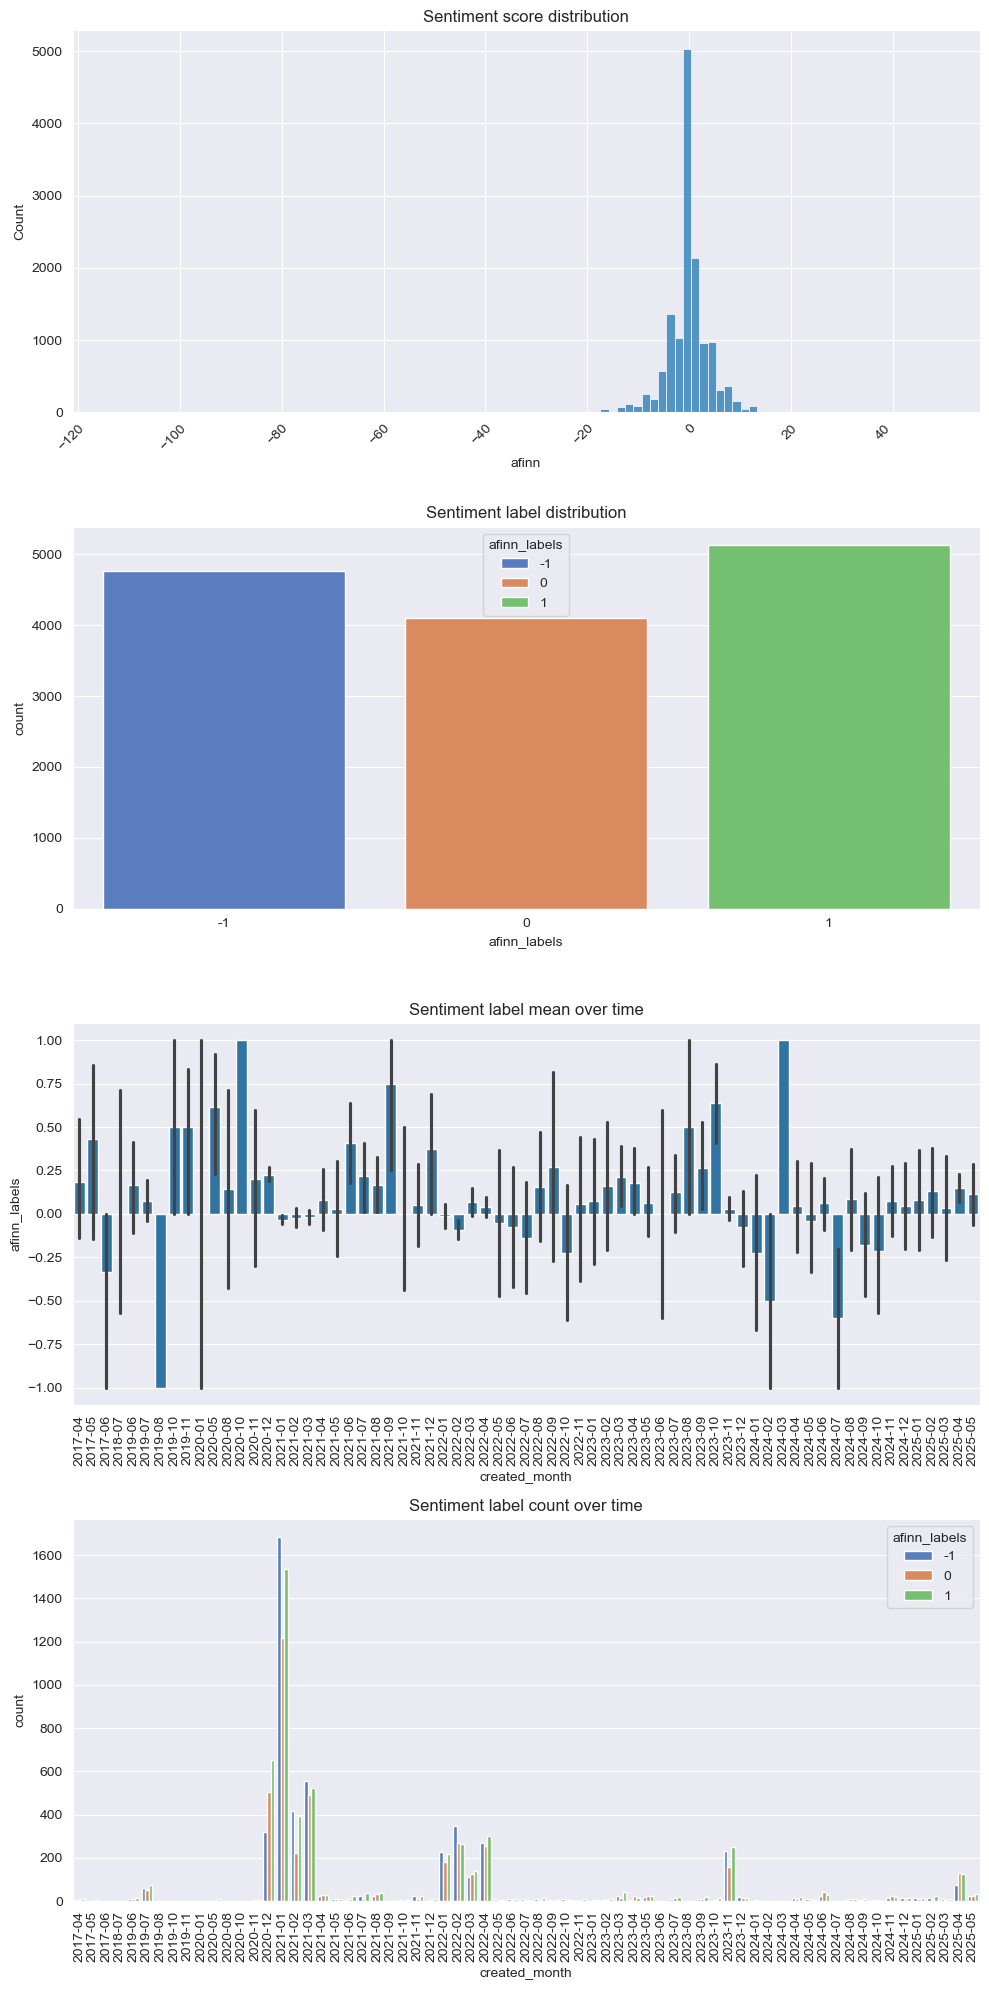

In [13]:
plot_results(df_ending_comments, score_col='afinn', label_col='afinn_labels', time_col='created_month')

Cool. Let's now focus more on the first spike, at around 2020-12 to 2021-03, the period after the manga ending release.

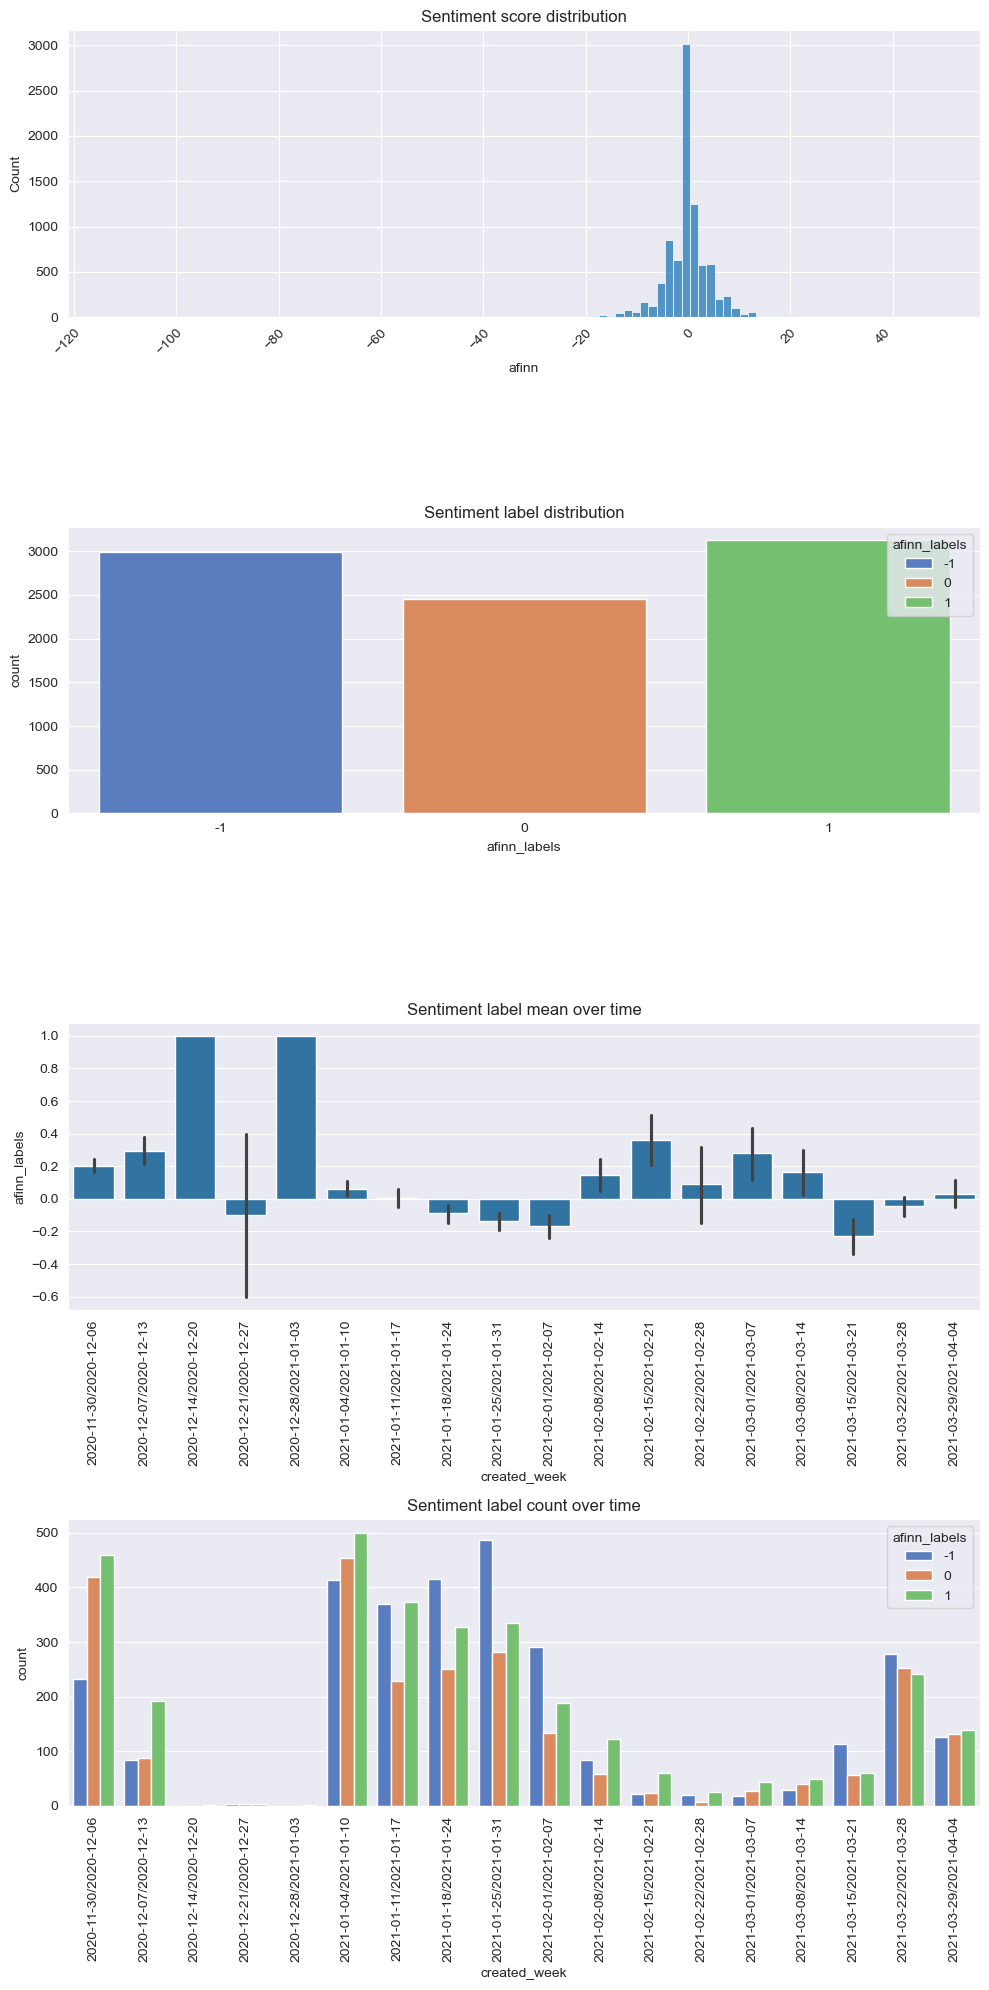

In [14]:
plot_results(df_ending_comments, score_col='afinn', 
             label_col='afinn_labels', time_col='created_week',
             min_time='2020-12', max_time='2021-04')

Secondly, let's analyze the second spike: from 2022-01 to 2022-04, the period of season 4, part 2 of the anime.

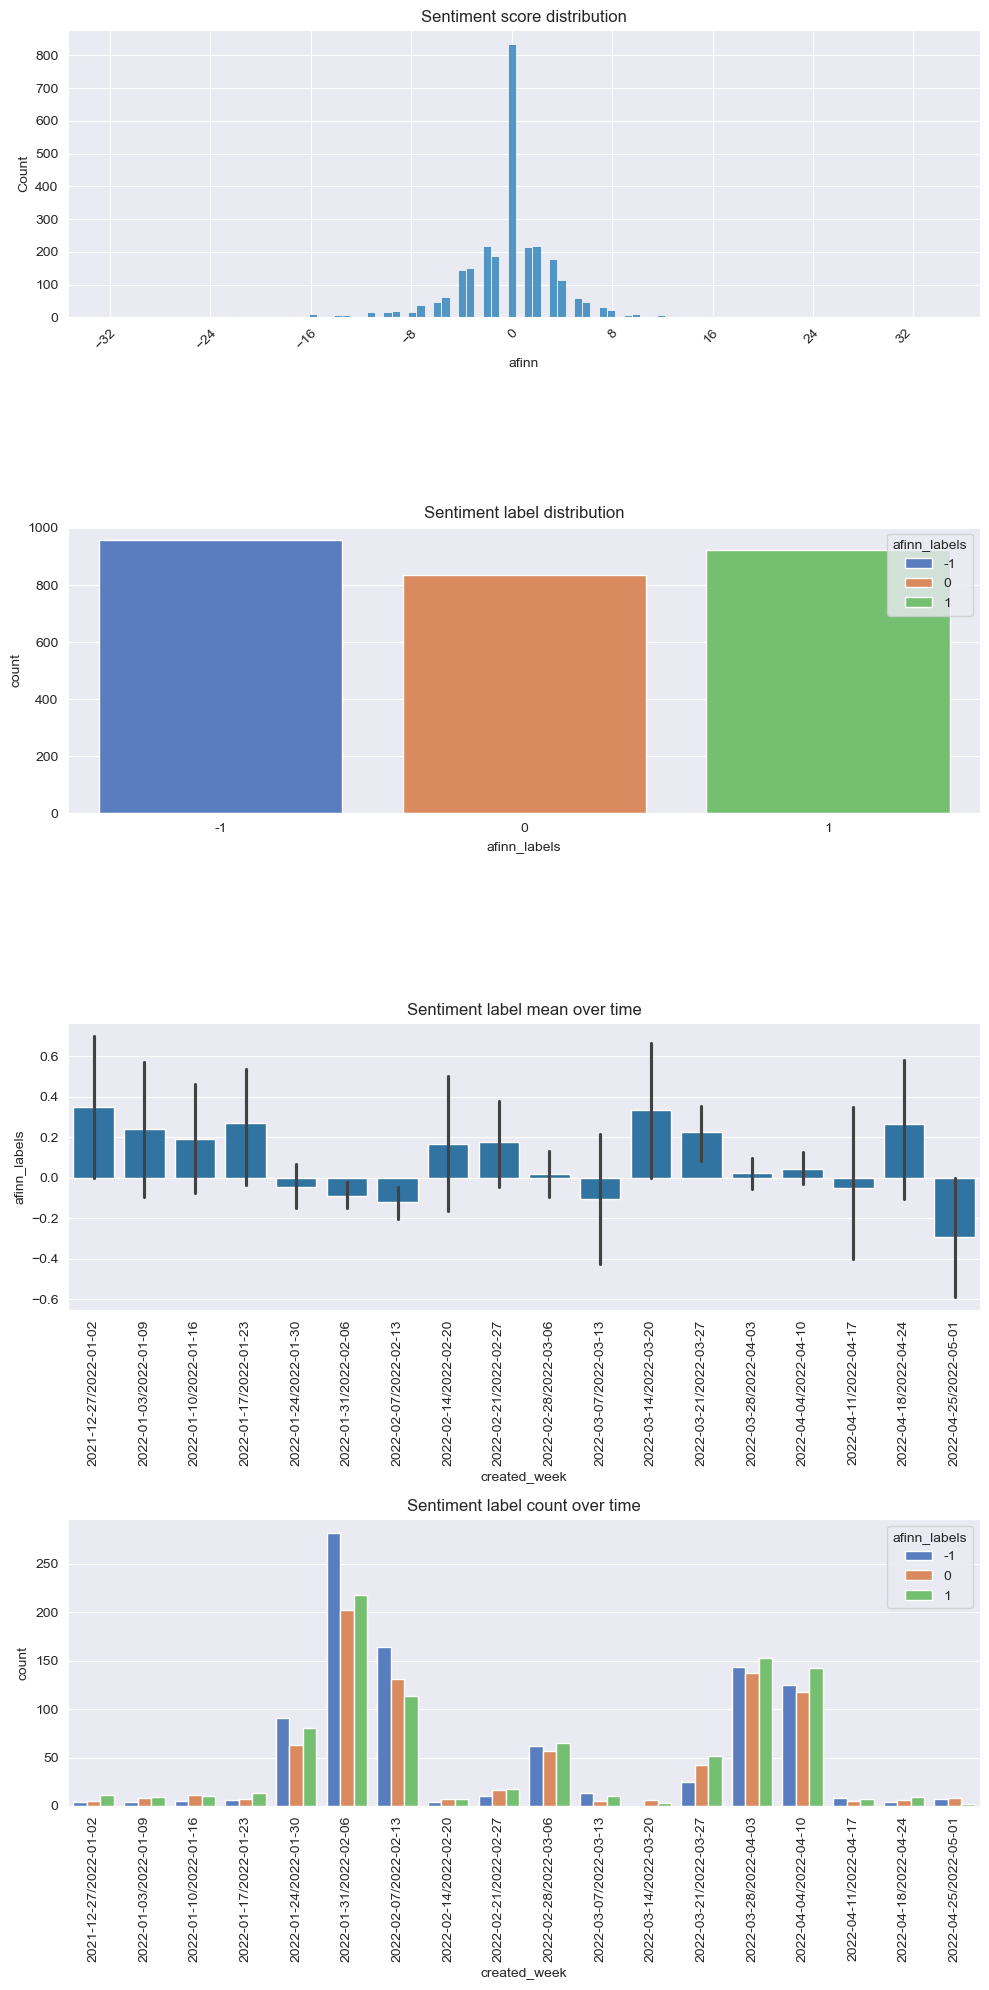

In [15]:
plot_results(df_ending_comments, score_col='afinn', 
             label_col='afinn_labels', time_col='created_week',
             min_time='2022-01', max_time='2022-05')

The third spike is from 2023-11 to 2023-12, the anime ending.

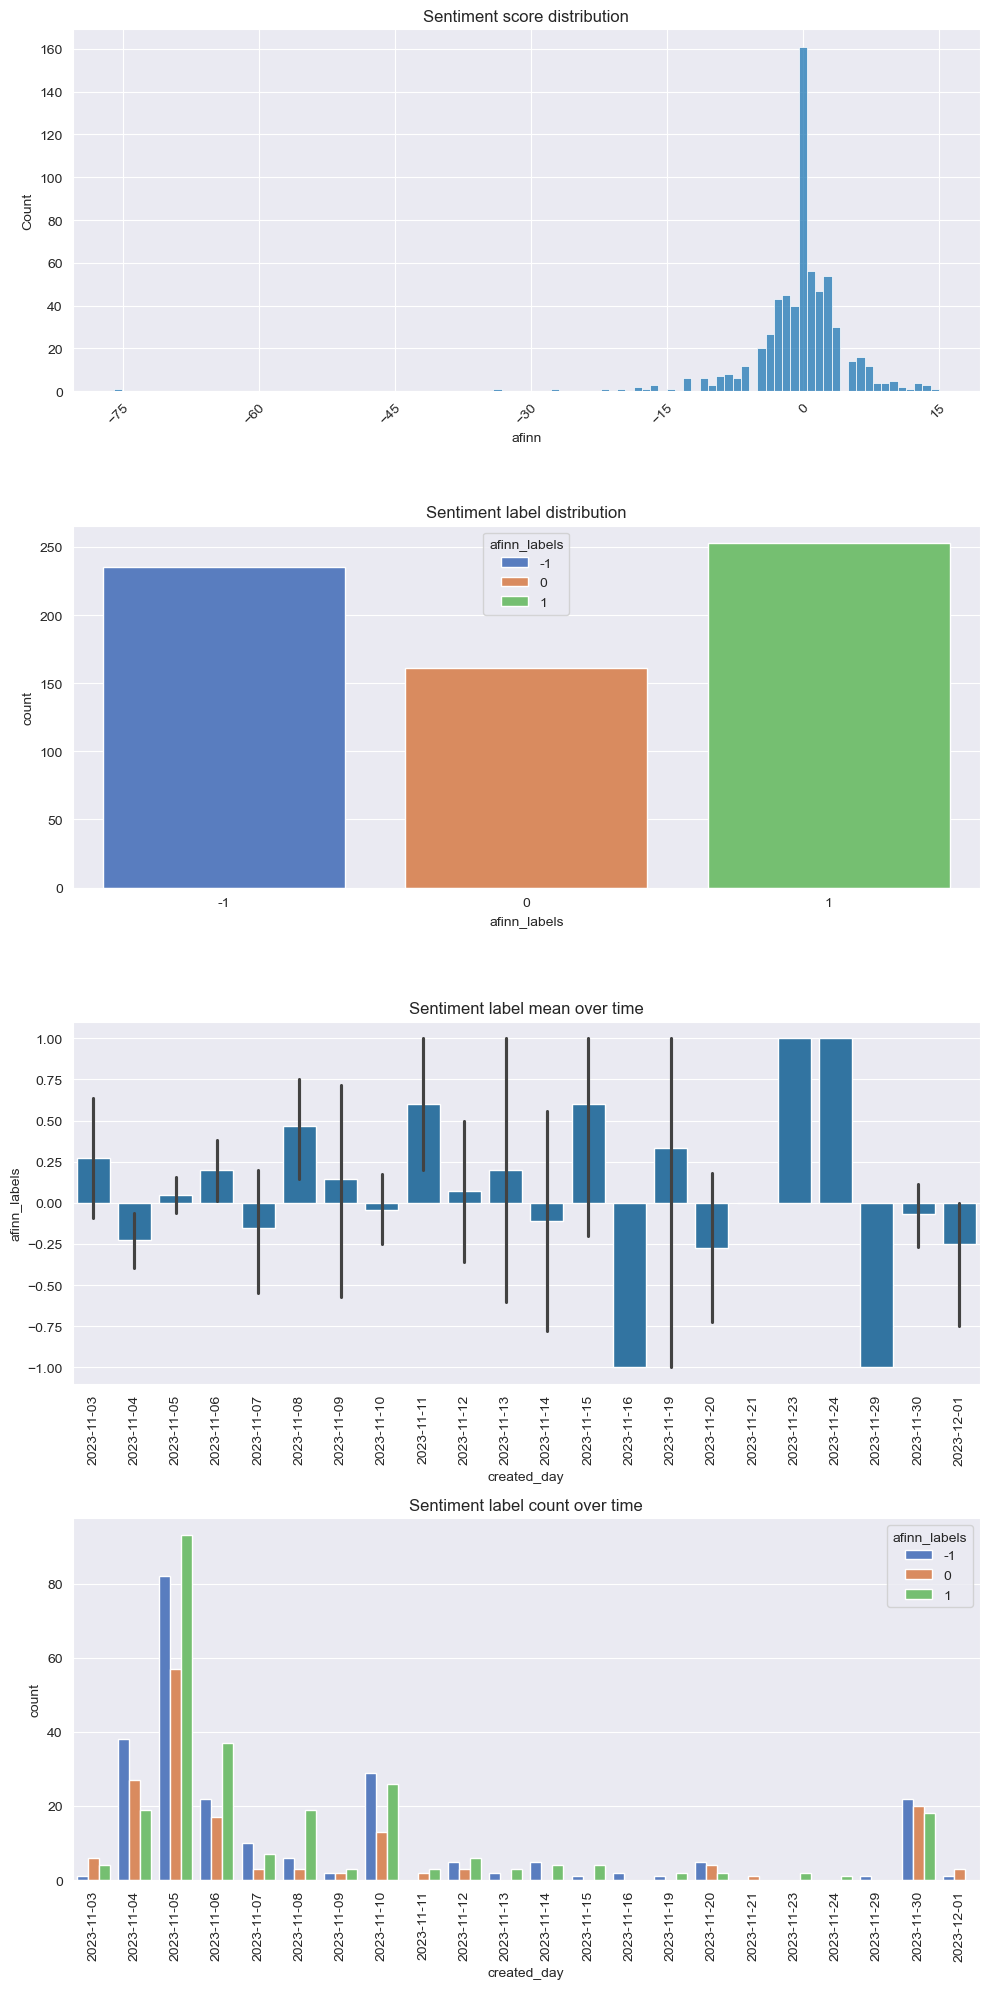

In [16]:
plot_results(df_ending_comments, score_col='afinn', 
             label_col='afinn_labels', time_col='created_day',
             min_time='2023-11', max_time='2023-12')

Lastly, between 2025-04 and 2025-05. This is the streaming release of Attack on Titan: THE LAST ATTACK, a movie that compiles the final chapters of the anime with enhanced visuals and sound

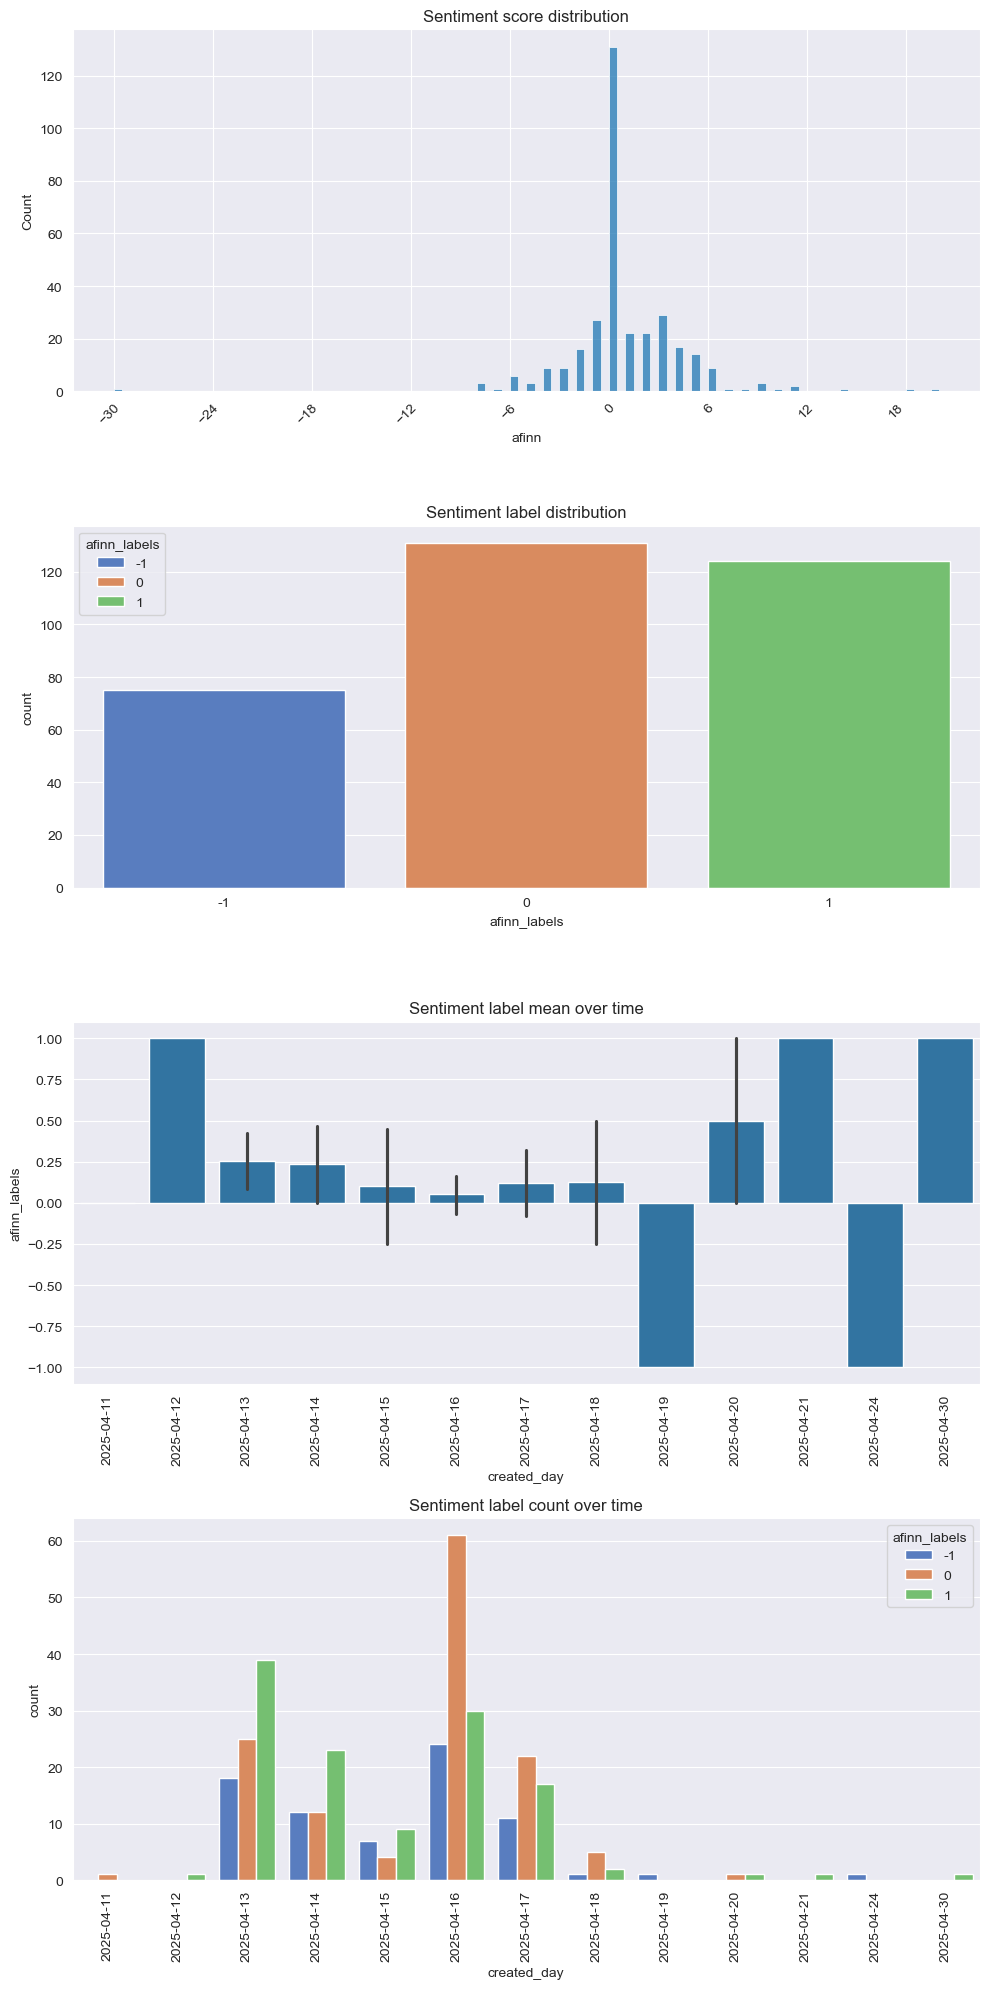

In [17]:
plot_results(df_ending_comments, score_col='afinn', 
             label_col='afinn_labels', time_col='created_day',
             min_time='2025-04', max_time='2025-05')

### Sentiment Analysis: nltk opinion lexicon

Now we do the same for the second method.

In [18]:
pos_list = set(opinion_lexicon.positive())
neg_list = set(opinion_lexicon.negative())

def sentiment_sum(tokens):
    sentiment = 0
    for token in tokens:
        if token in pos_list:
            sentiment += 1
        elif token in neg_list:
            sentiment -= 1
    return sentiment

df_ending_comments["opinion_lexicon"] = df_ending_comments["tokens"].apply(sentiment_sum)
df_ending_comments["opinion_lexicon_labels"] = df_ending_comments["opinion_lexicon"].apply(label_mapping, args=(0, 0,))

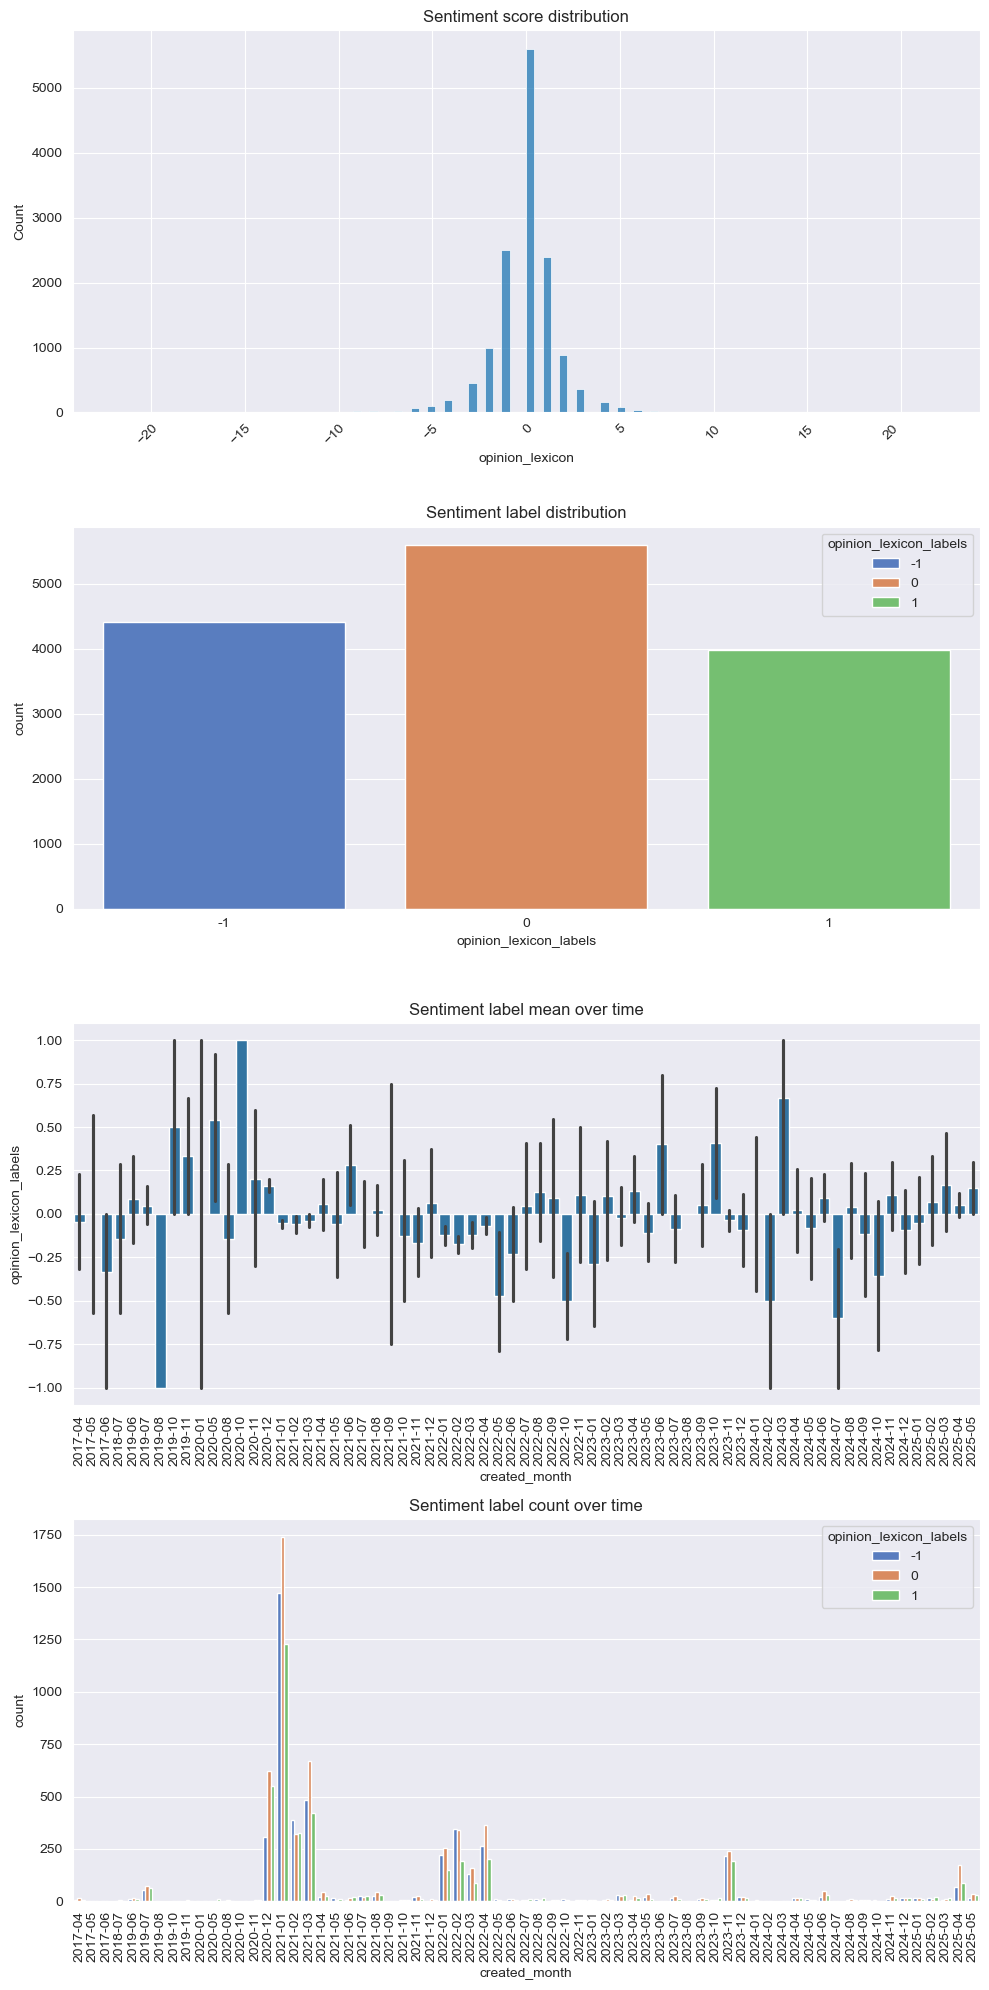

In [19]:
plot_results(df_ending_comments, score_col='opinion_lexicon', label_col='opinion_lexicon_labels', time_col='created_month')

First spike:

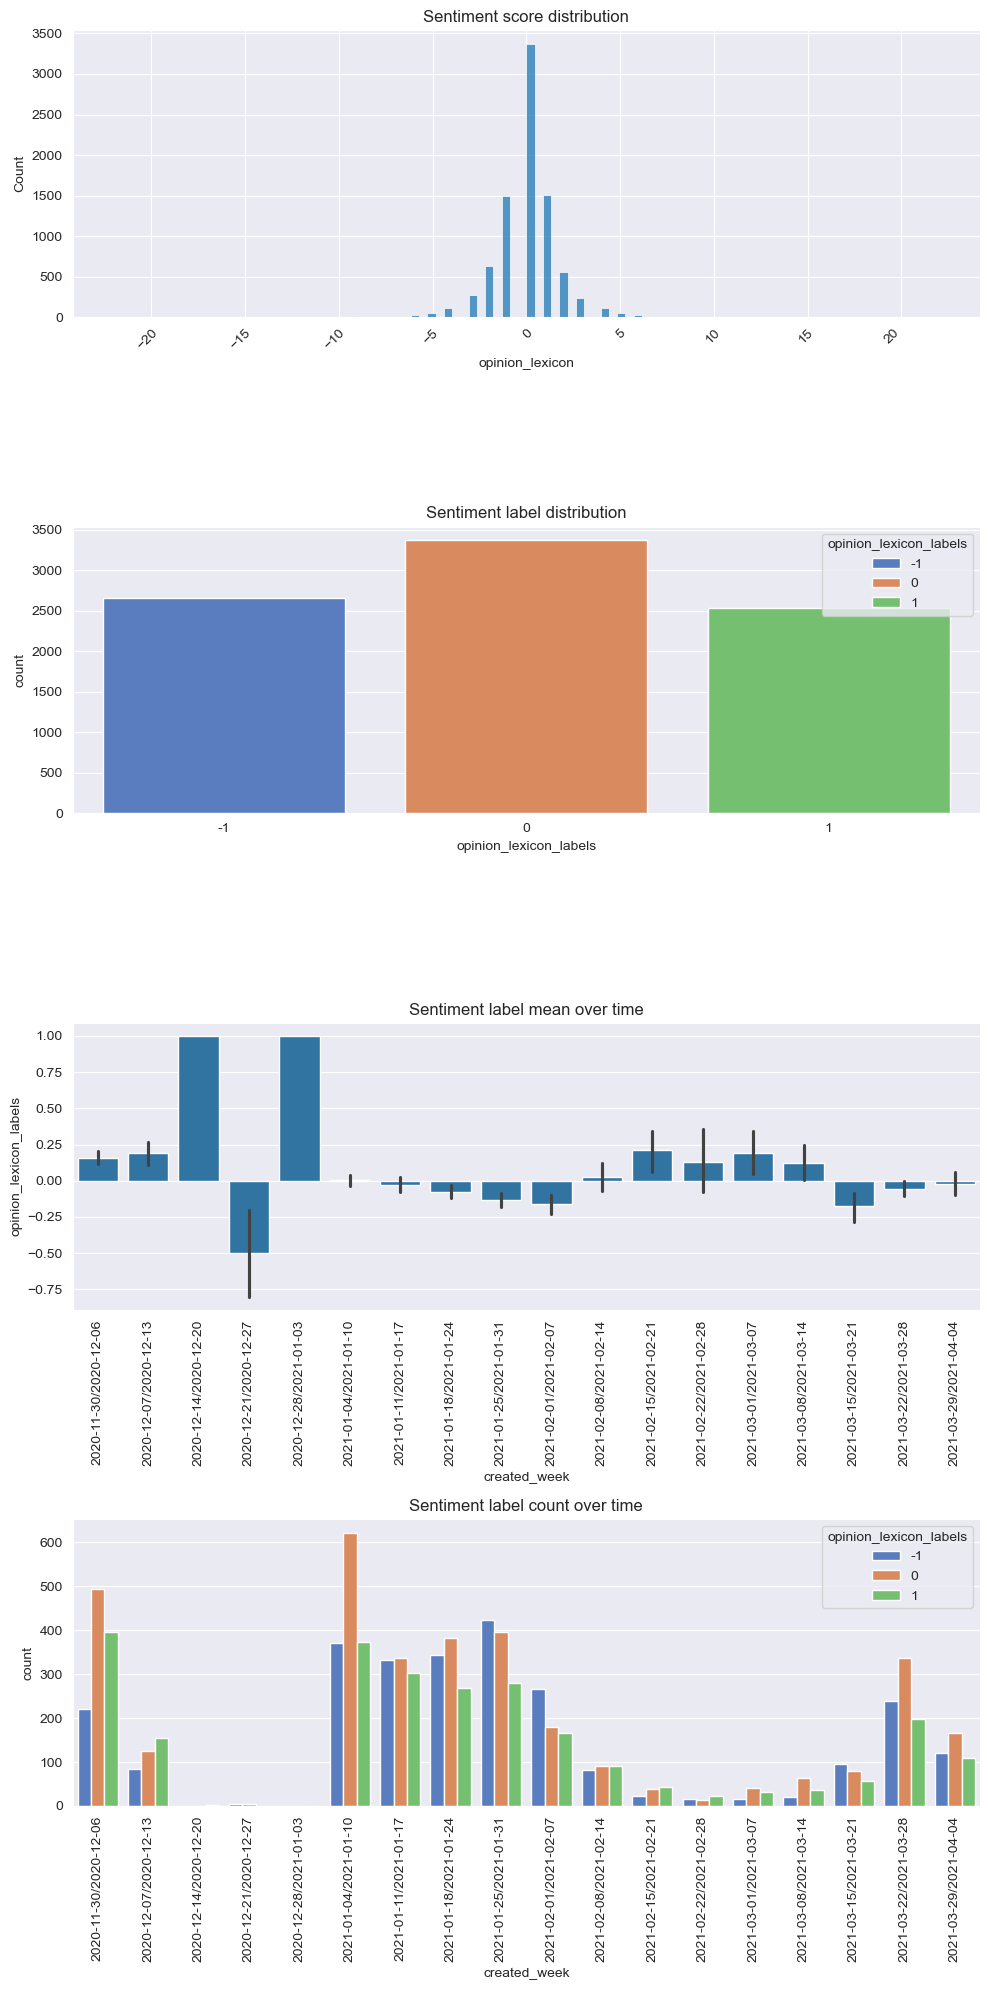

In [20]:
plot_results(df_ending_comments, score_col='opinion_lexicon', 
             label_col='opinion_lexicon_labels', time_col='created_week',
             min_time='2020-12', max_time='2021-04')

Second spike:

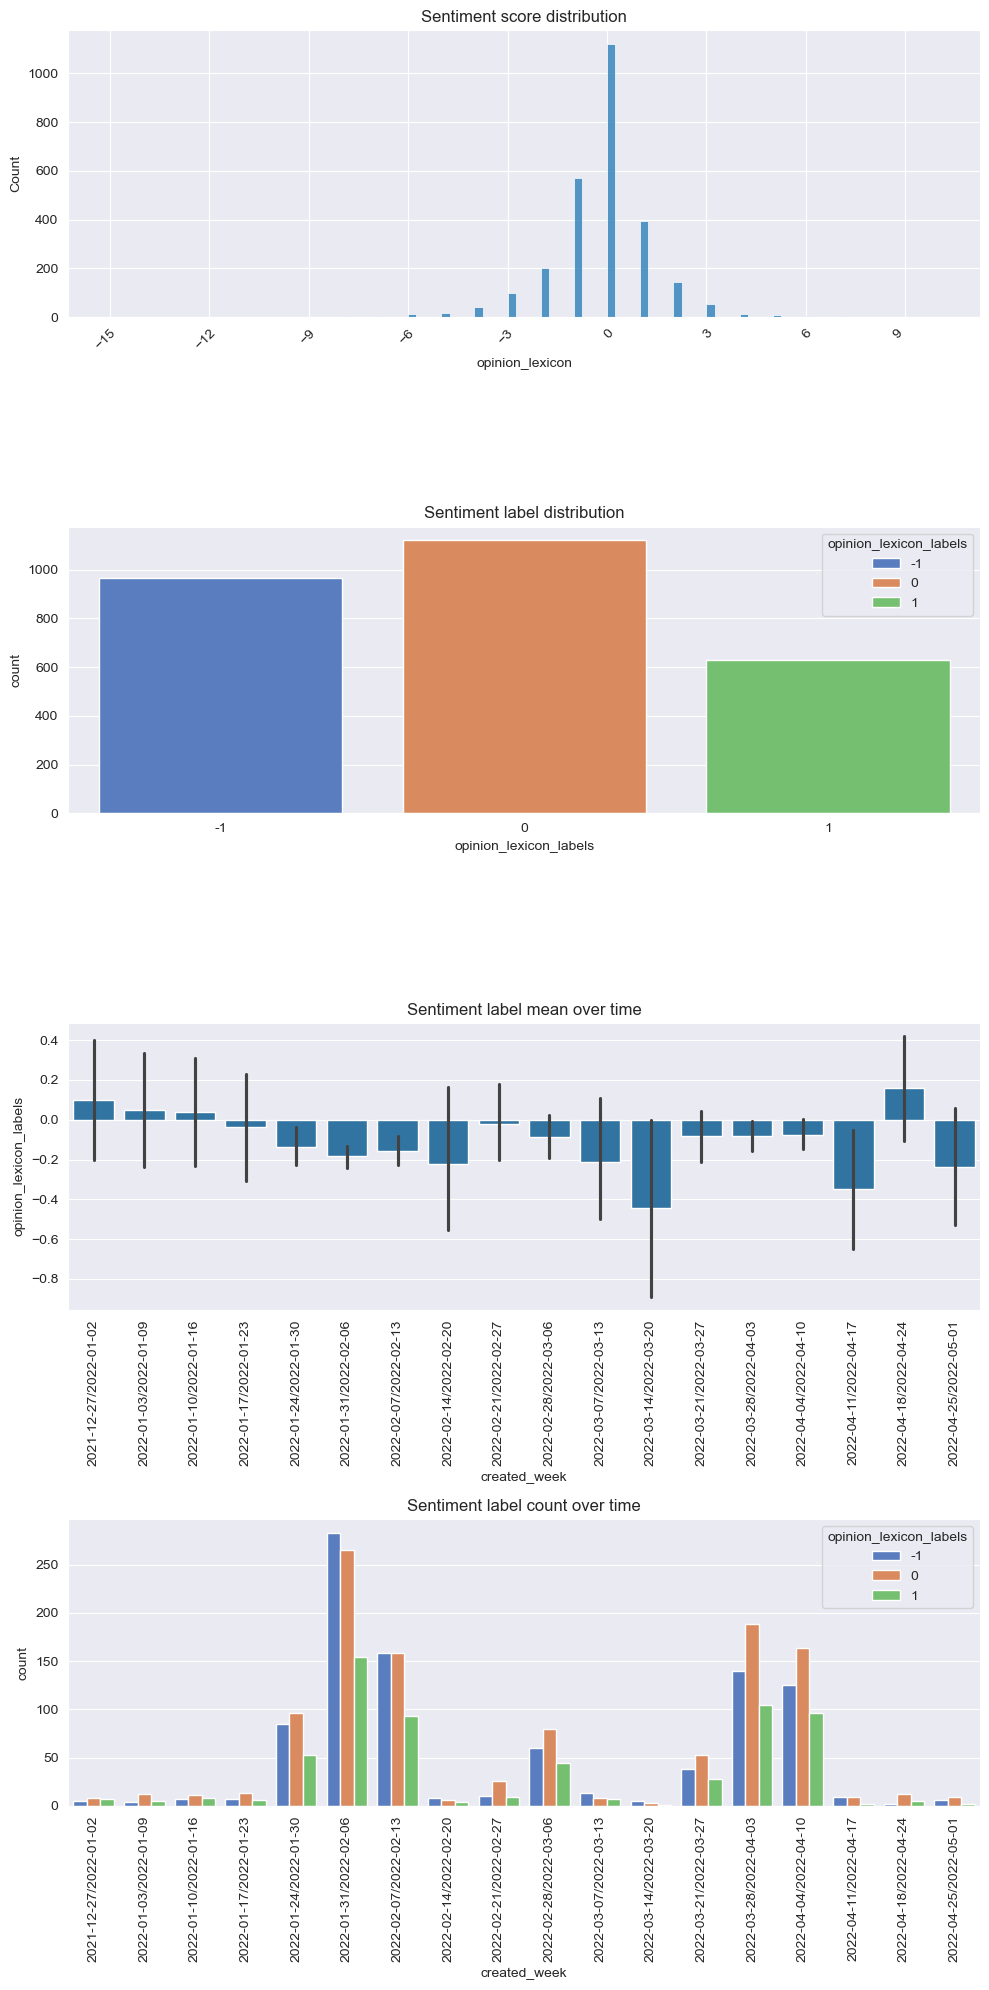

In [21]:
plot_results(df_ending_comments, score_col='opinion_lexicon', 
             label_col='opinion_lexicon_labels', time_col='created_week',
             min_time='2022-01', max_time='2022-05')

Third spike:

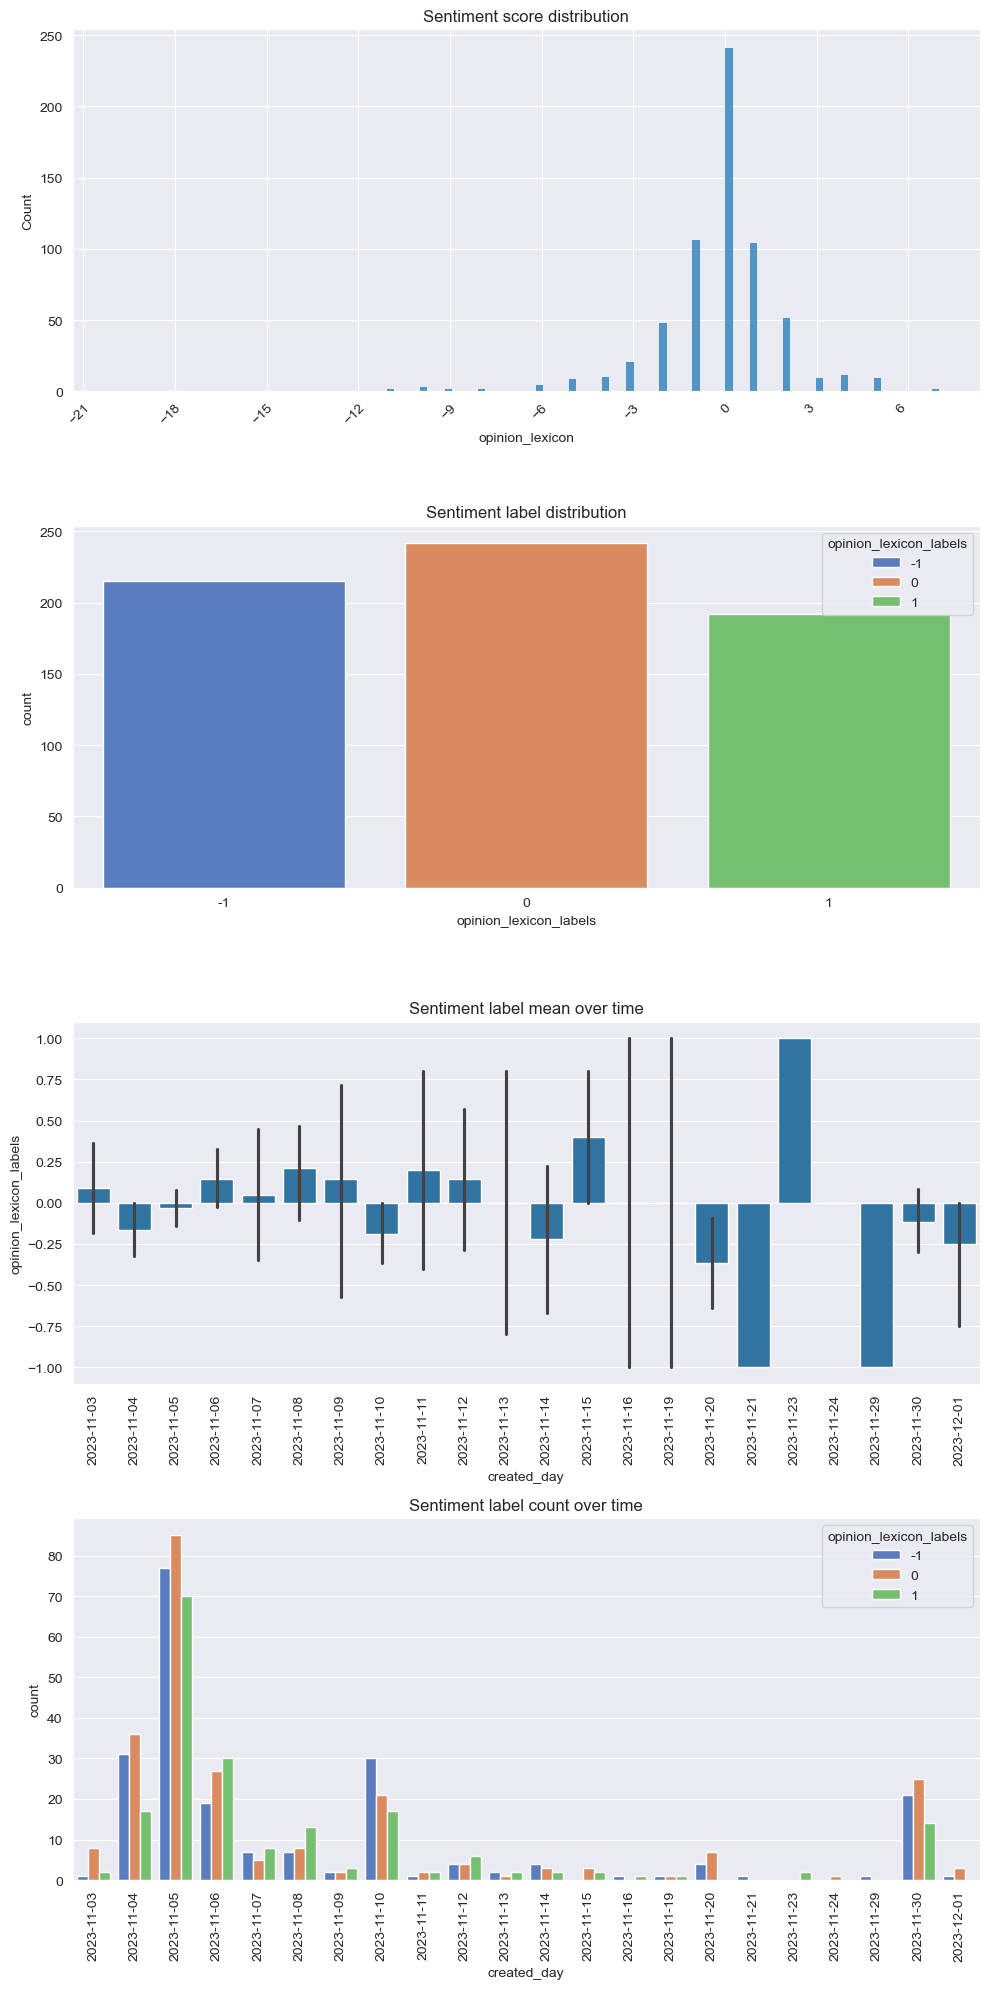

In [22]:
plot_results(df_ending_comments, score_col='opinion_lexicon', 
             label_col='opinion_lexicon_labels', time_col='created_day',
             min_time='2023-11', max_time='2023-12')

Last spike:

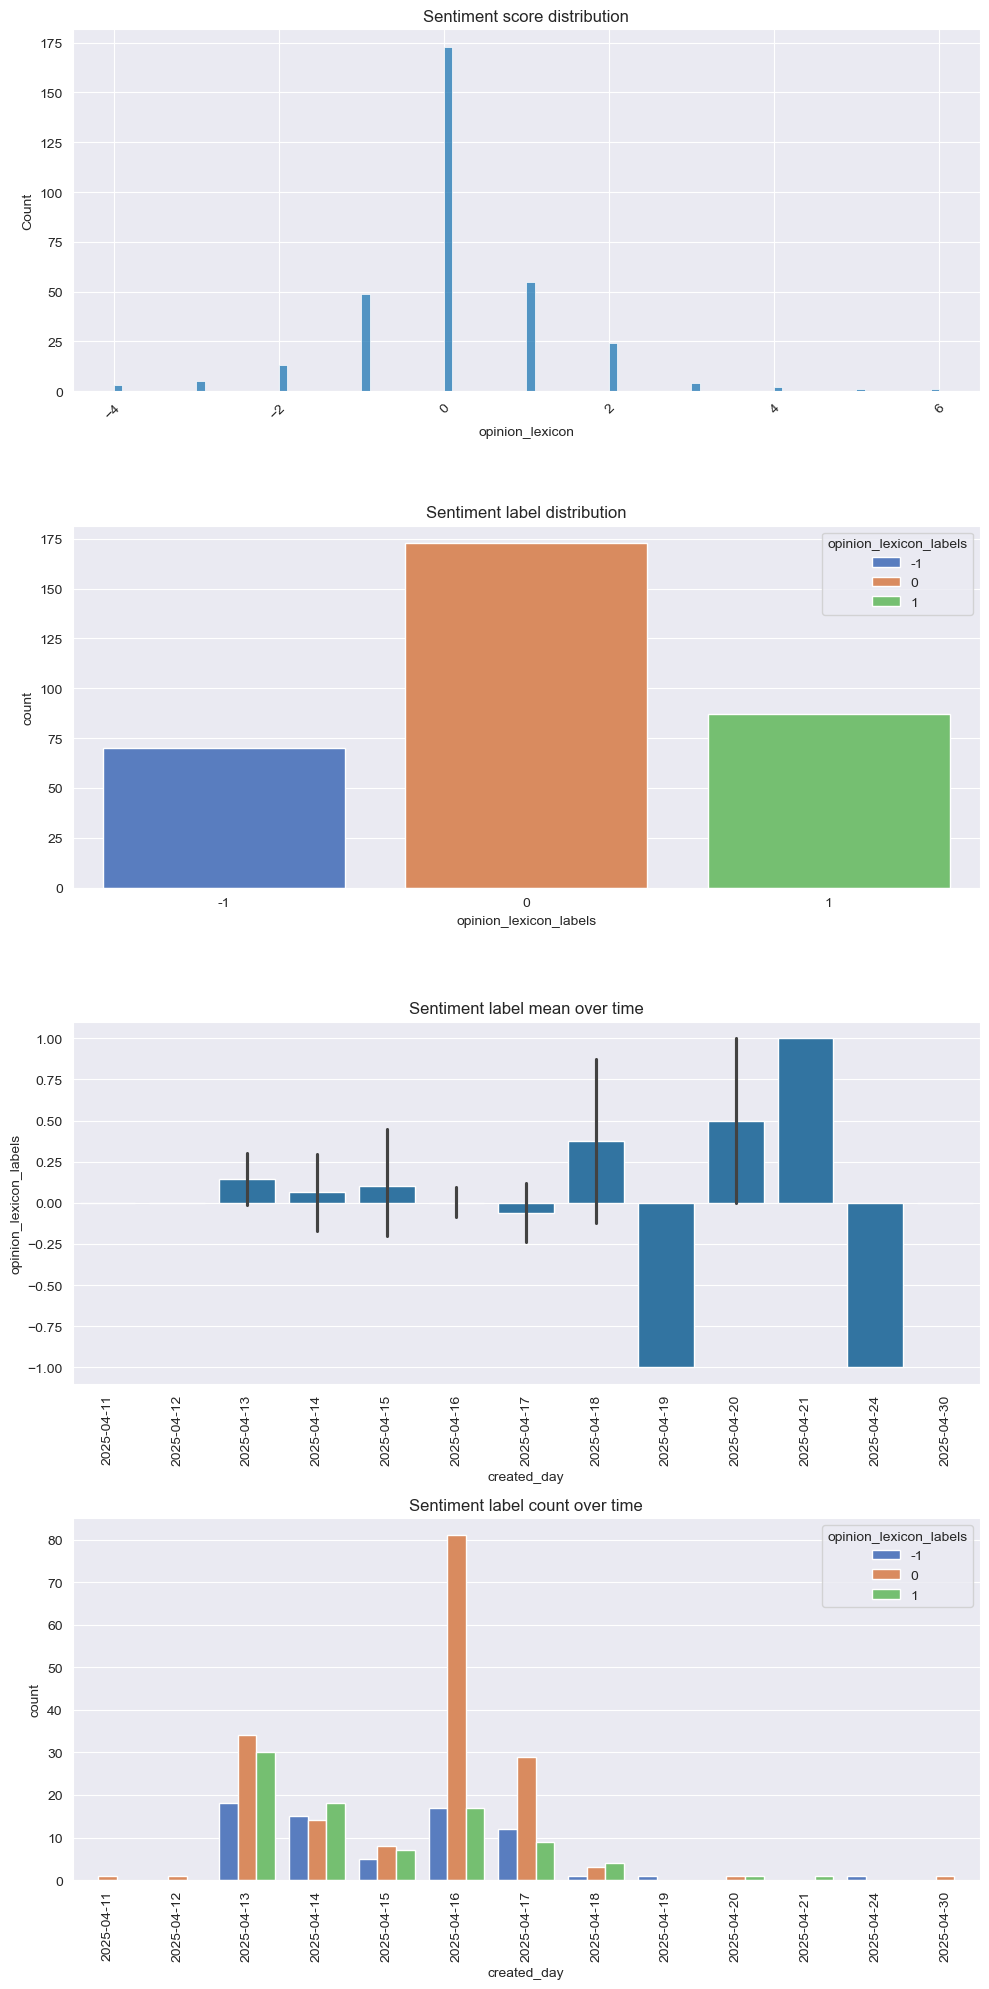

In [23]:
plot_results(df_ending_comments, score_col='opinion_lexicon', 
             label_col='opinion_lexicon_labels', time_col='created_day',
             min_time='2025-04', max_time='2025-05')

### Sentiment Analysis: Vader

In [24]:
sia = SentimentIntensityAnalyzer()

def vader(text):
    sentiment_dict = sia.polarity_scores(text)
    return sentiment_dict["compound"]

df_ending_comments["vader"] = df_ending_comments["text_comment"].apply(vader)
df_ending_comments["vader_labels"] = df_ending_comments["vader"].apply(label_mapping, args=(0, 0,))

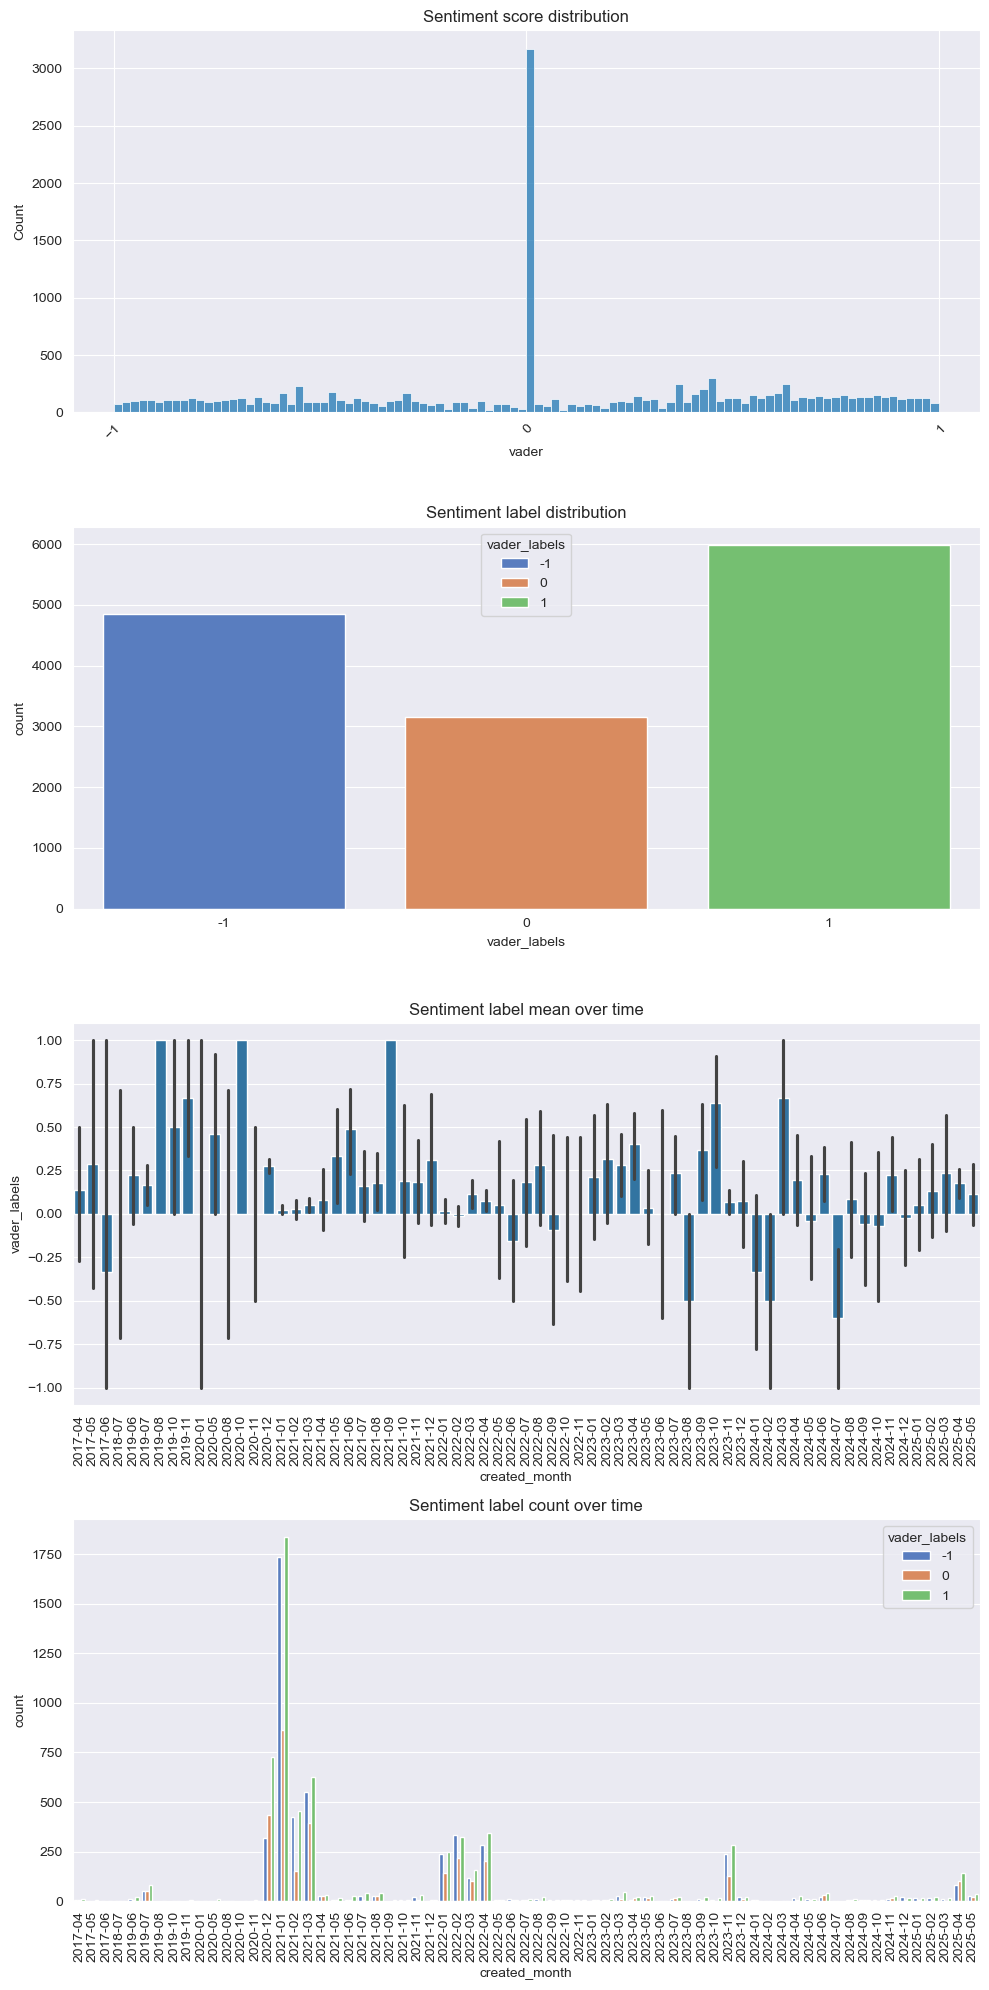

In [25]:
plot_results(df_ending_comments, score_col='vader', label_col='vader_labels', time_col='created_month')

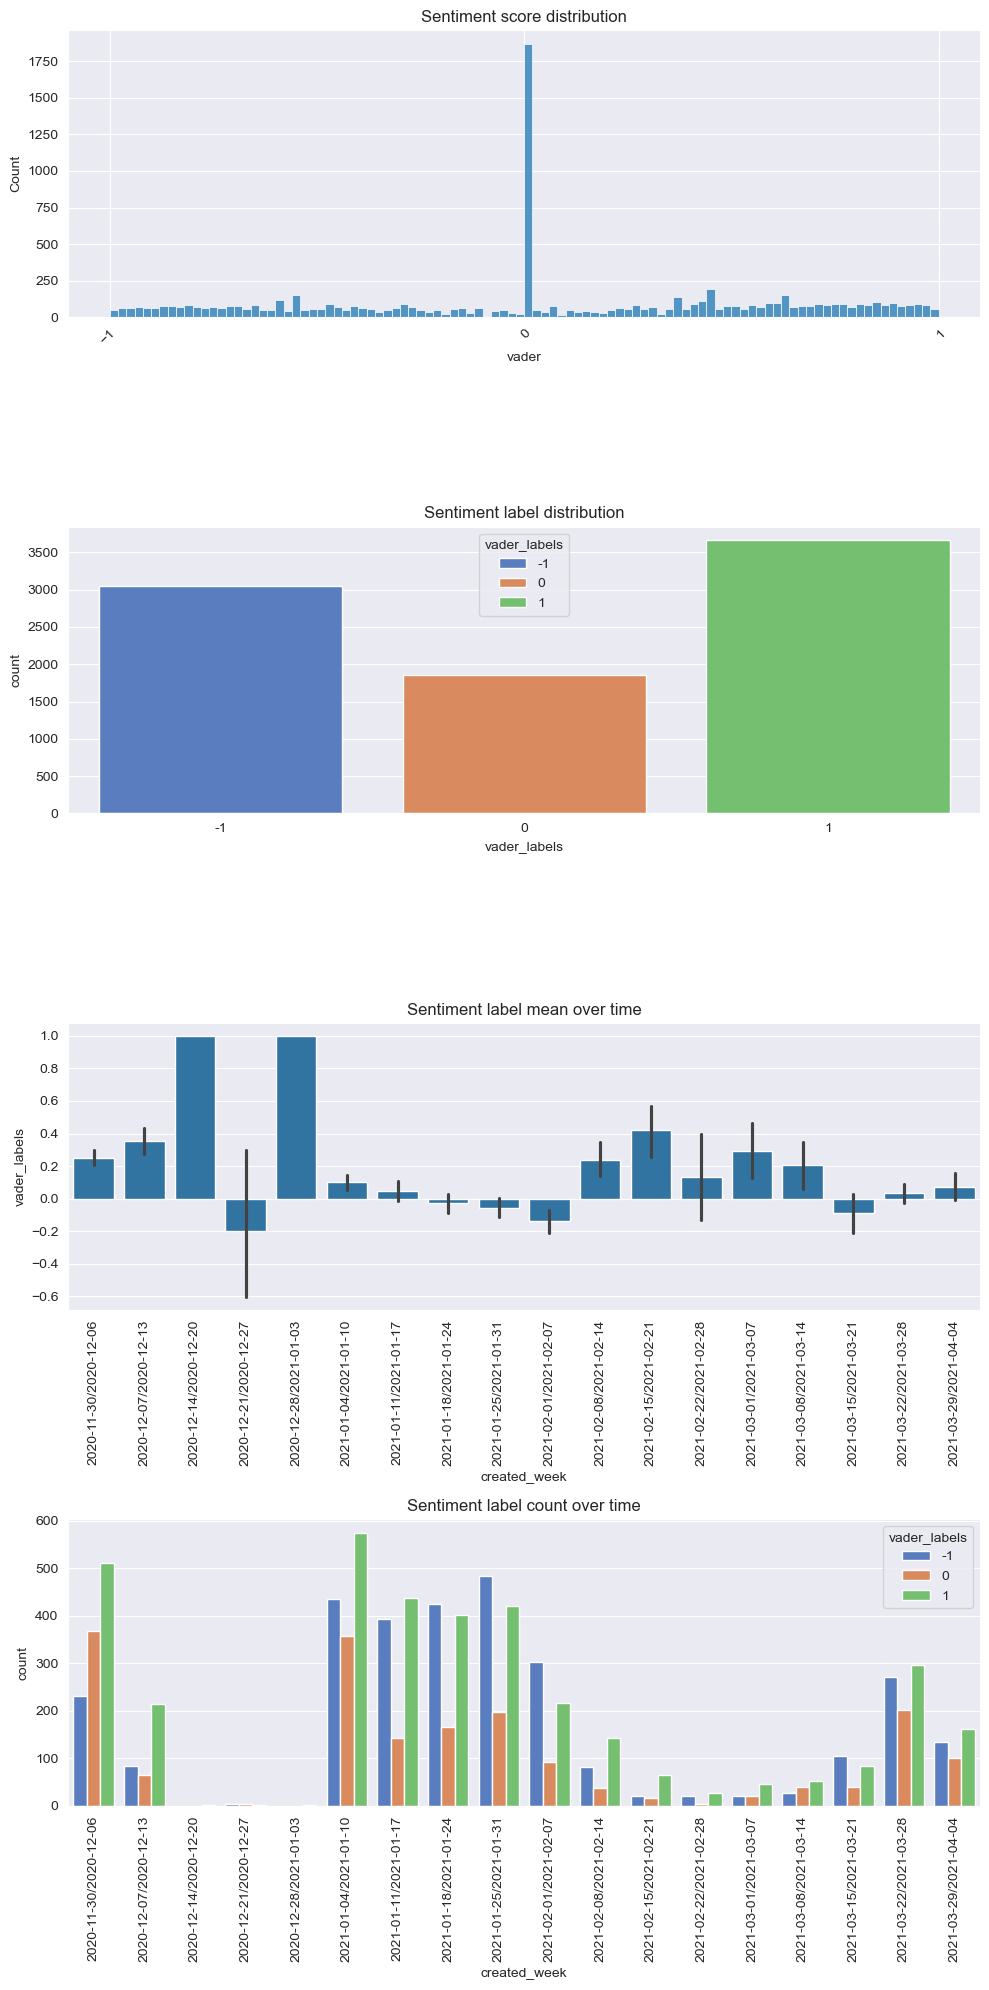

In [26]:
plot_results(df_ending_comments, score_col='vader', 
             label_col='vader_labels', time_col='created_week',
             min_time='2020-12', max_time='2021-04')

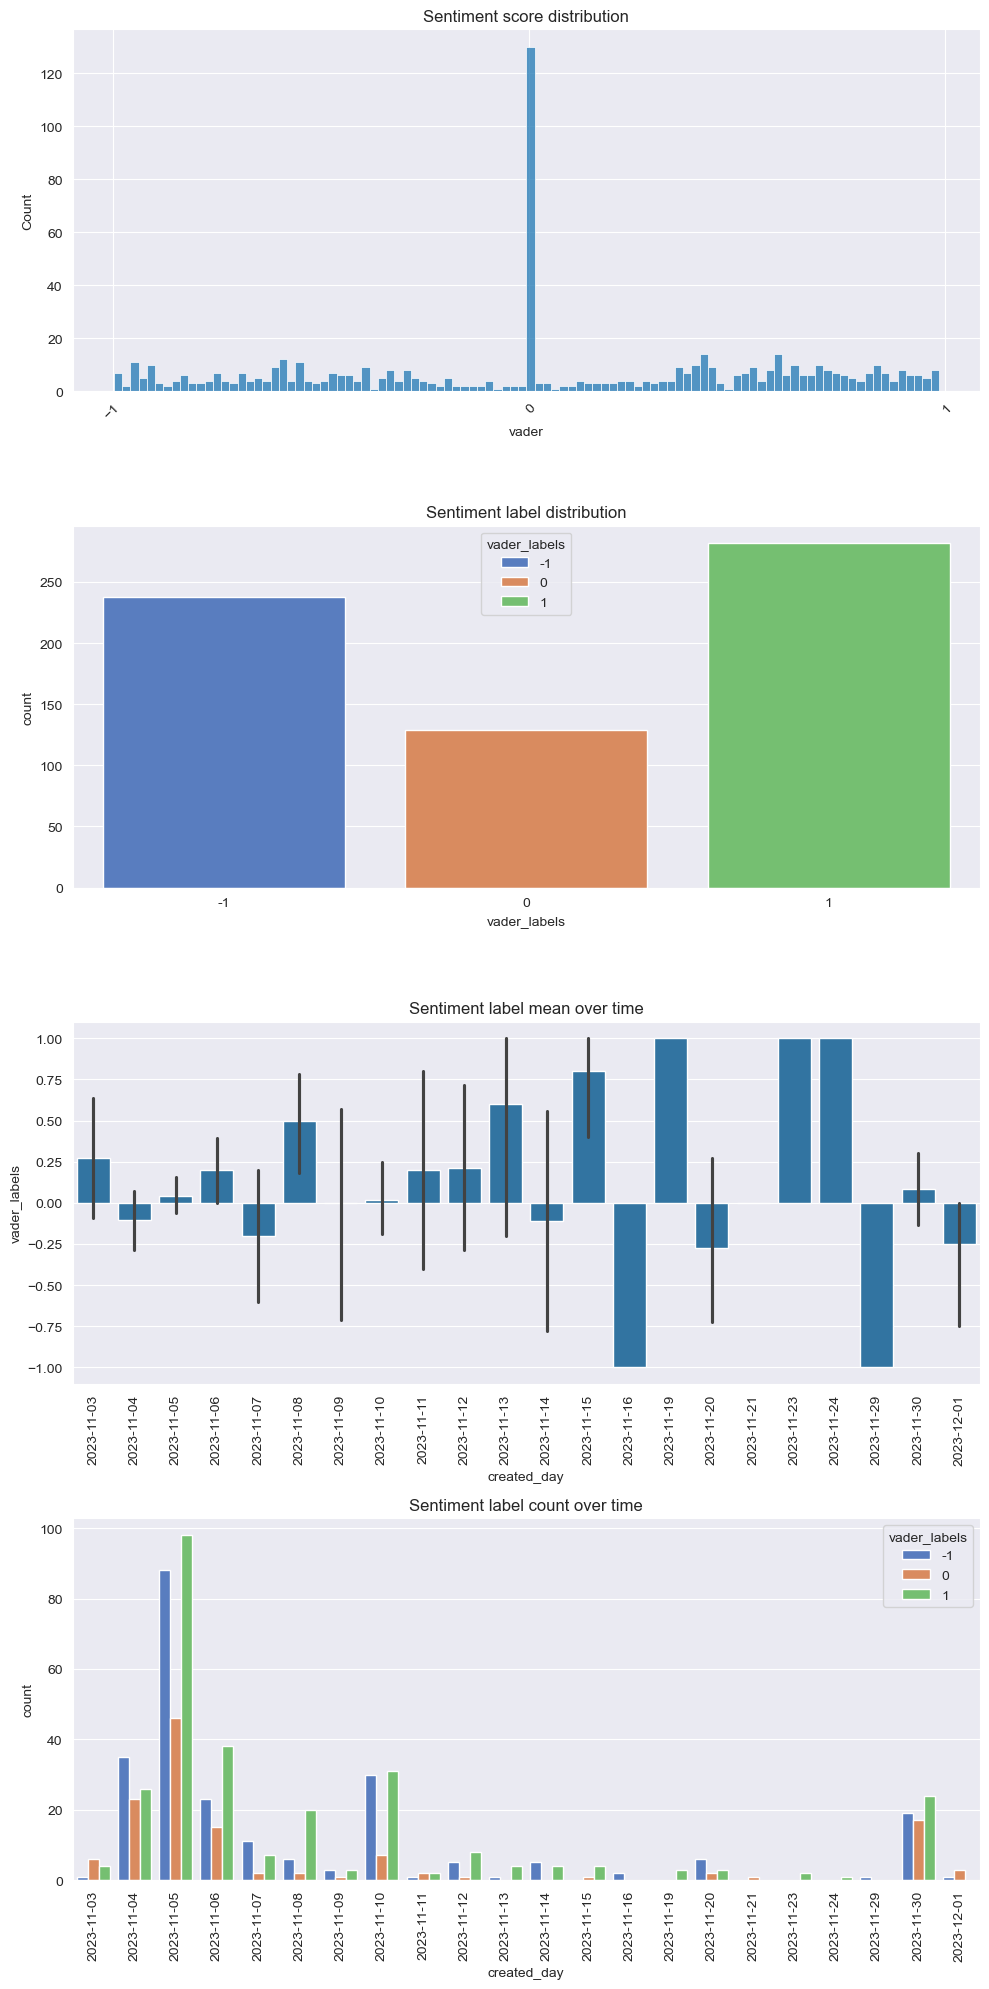

In [27]:
plot_results(df_ending_comments, score_col='vader', 
             label_col='vader_labels', time_col='created_day',
             min_time='2023-11', max_time='2023-12')

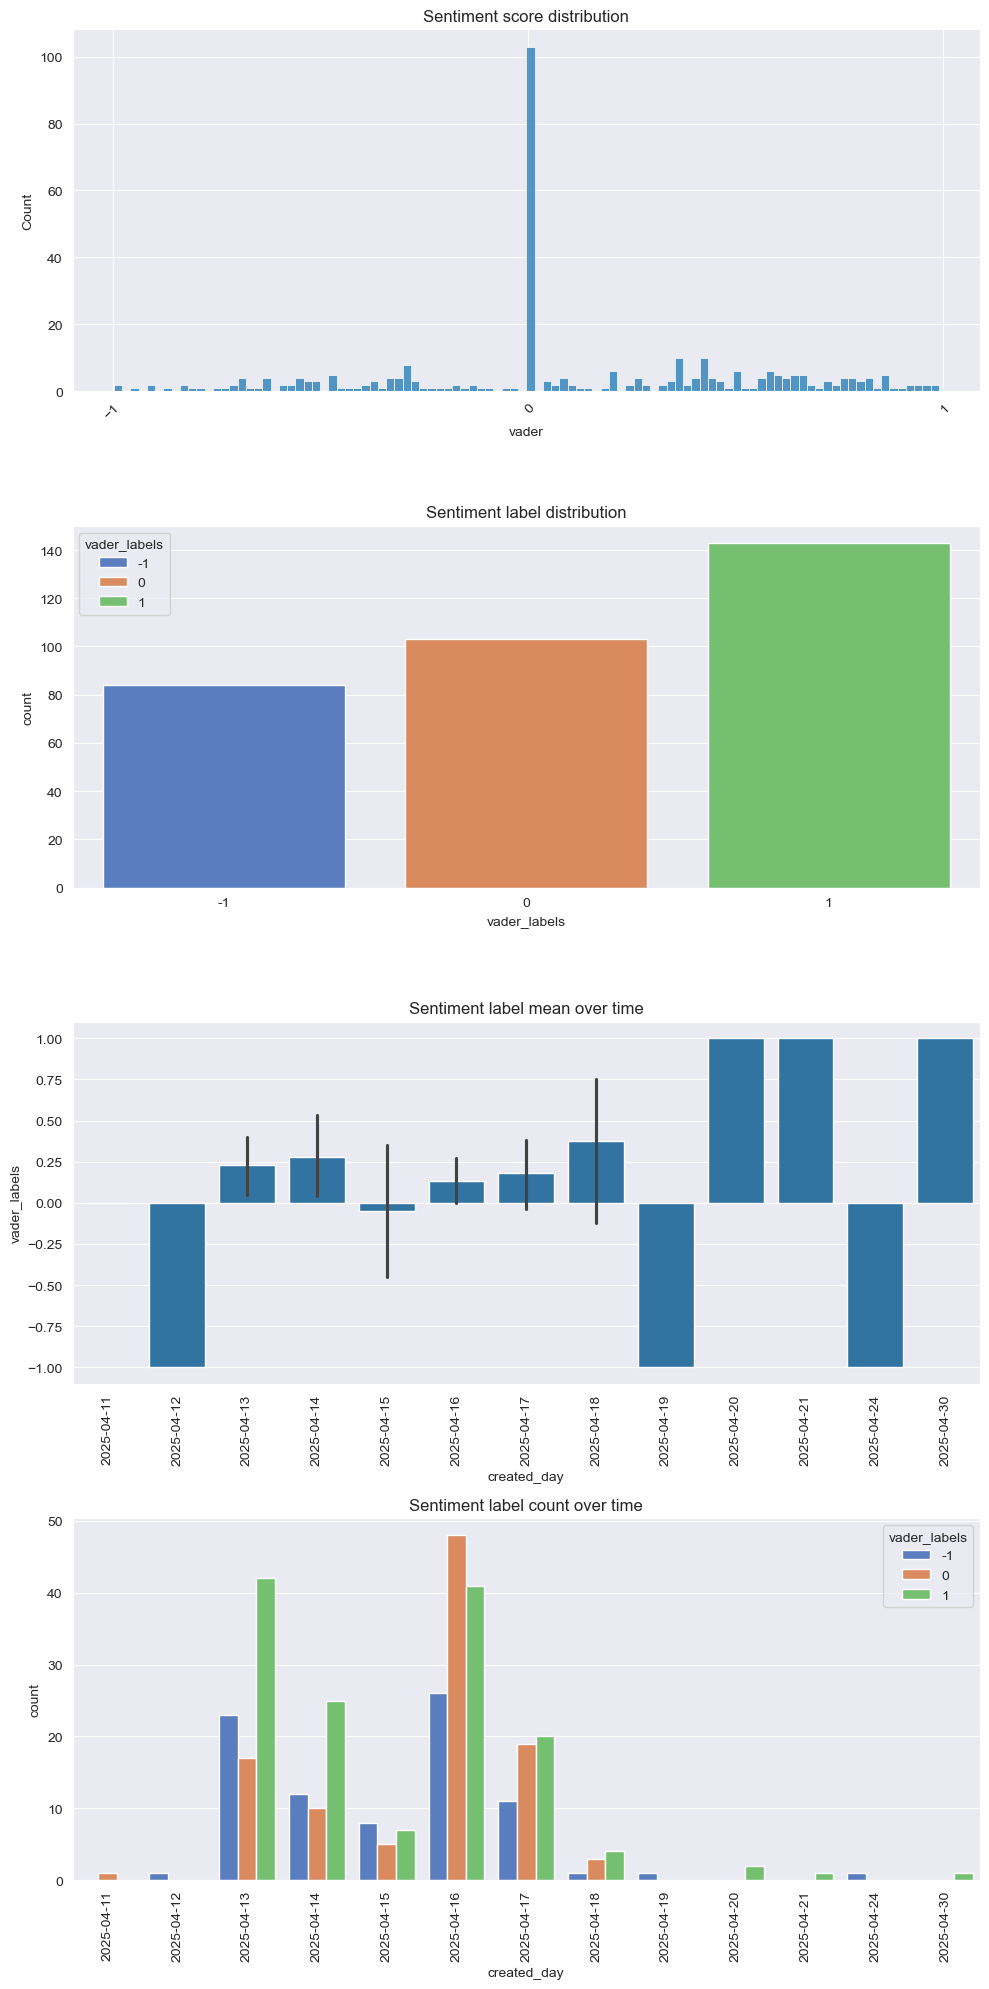

In [28]:
plot_results(df_ending_comments, score_col='vader', 
             label_col='vader_labels', time_col='created_day',
             min_time='2025-04', max_time='2025-05')

### Sentiment Analysis: Machine Learning

In [29]:
model_name = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)

In [30]:
index_to_label_map = {
    0: -2,
    1: -1,
    2: 0,
    3: 1,
    4: 2
}

def model_sentiment_score(texts, batch_size=32):
    results = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        batch_results = [index_to_label_map[p] for p in torch.argmax(probabilities, dim=-1).tolist()]
        results.extend(batch_results)
    return results

df_ending_comments["model_score"] = model_sentiment_score(df_ending_comments["text_comment"].to_list())

In [31]:
df_ending_comments["model_labels"] = df_ending_comments["model_score"].apply(label_mapping, args=(0,0))
df_ending_comments["model_labels"].value_counts()

model_labels
 1    5197
-1    4542
 0    4265
Name: count, dtype: int64

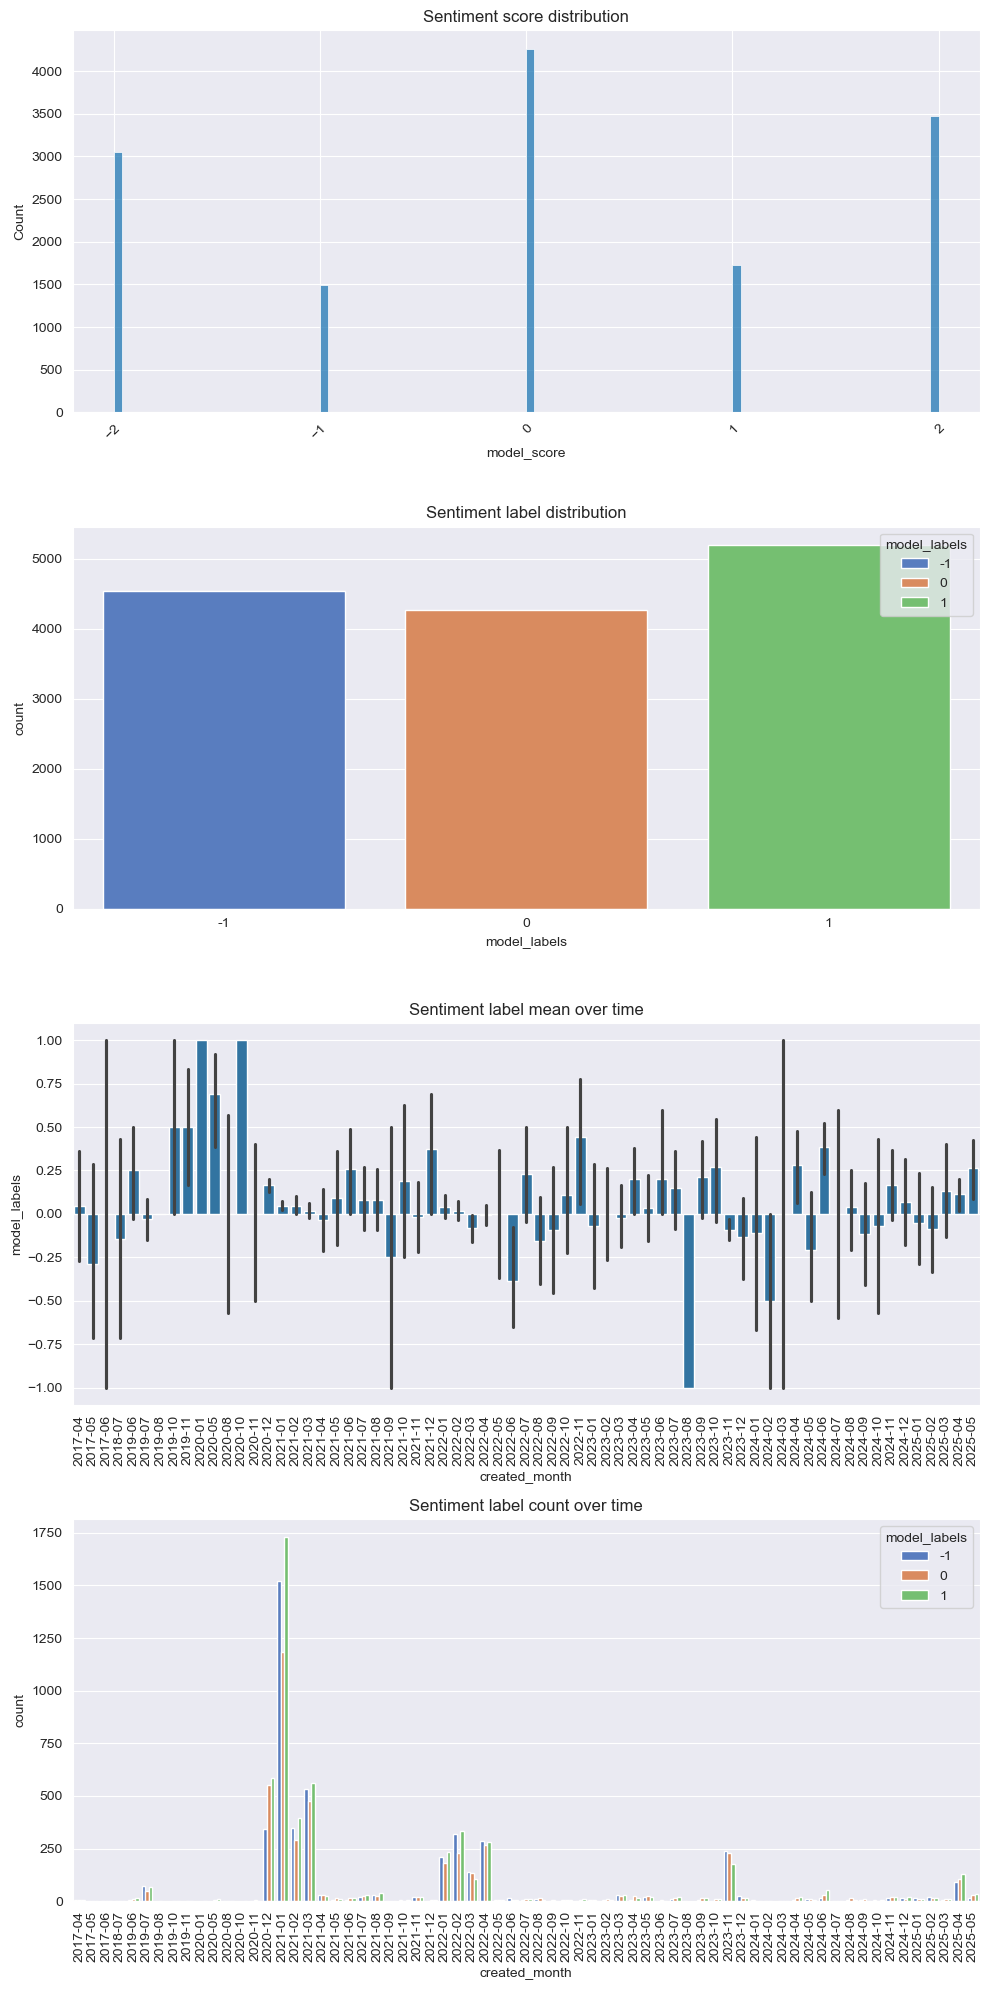

In [32]:
plot_results(df_ending_comments, score_col='model_score', label_col='model_labels', time_col='created_month')

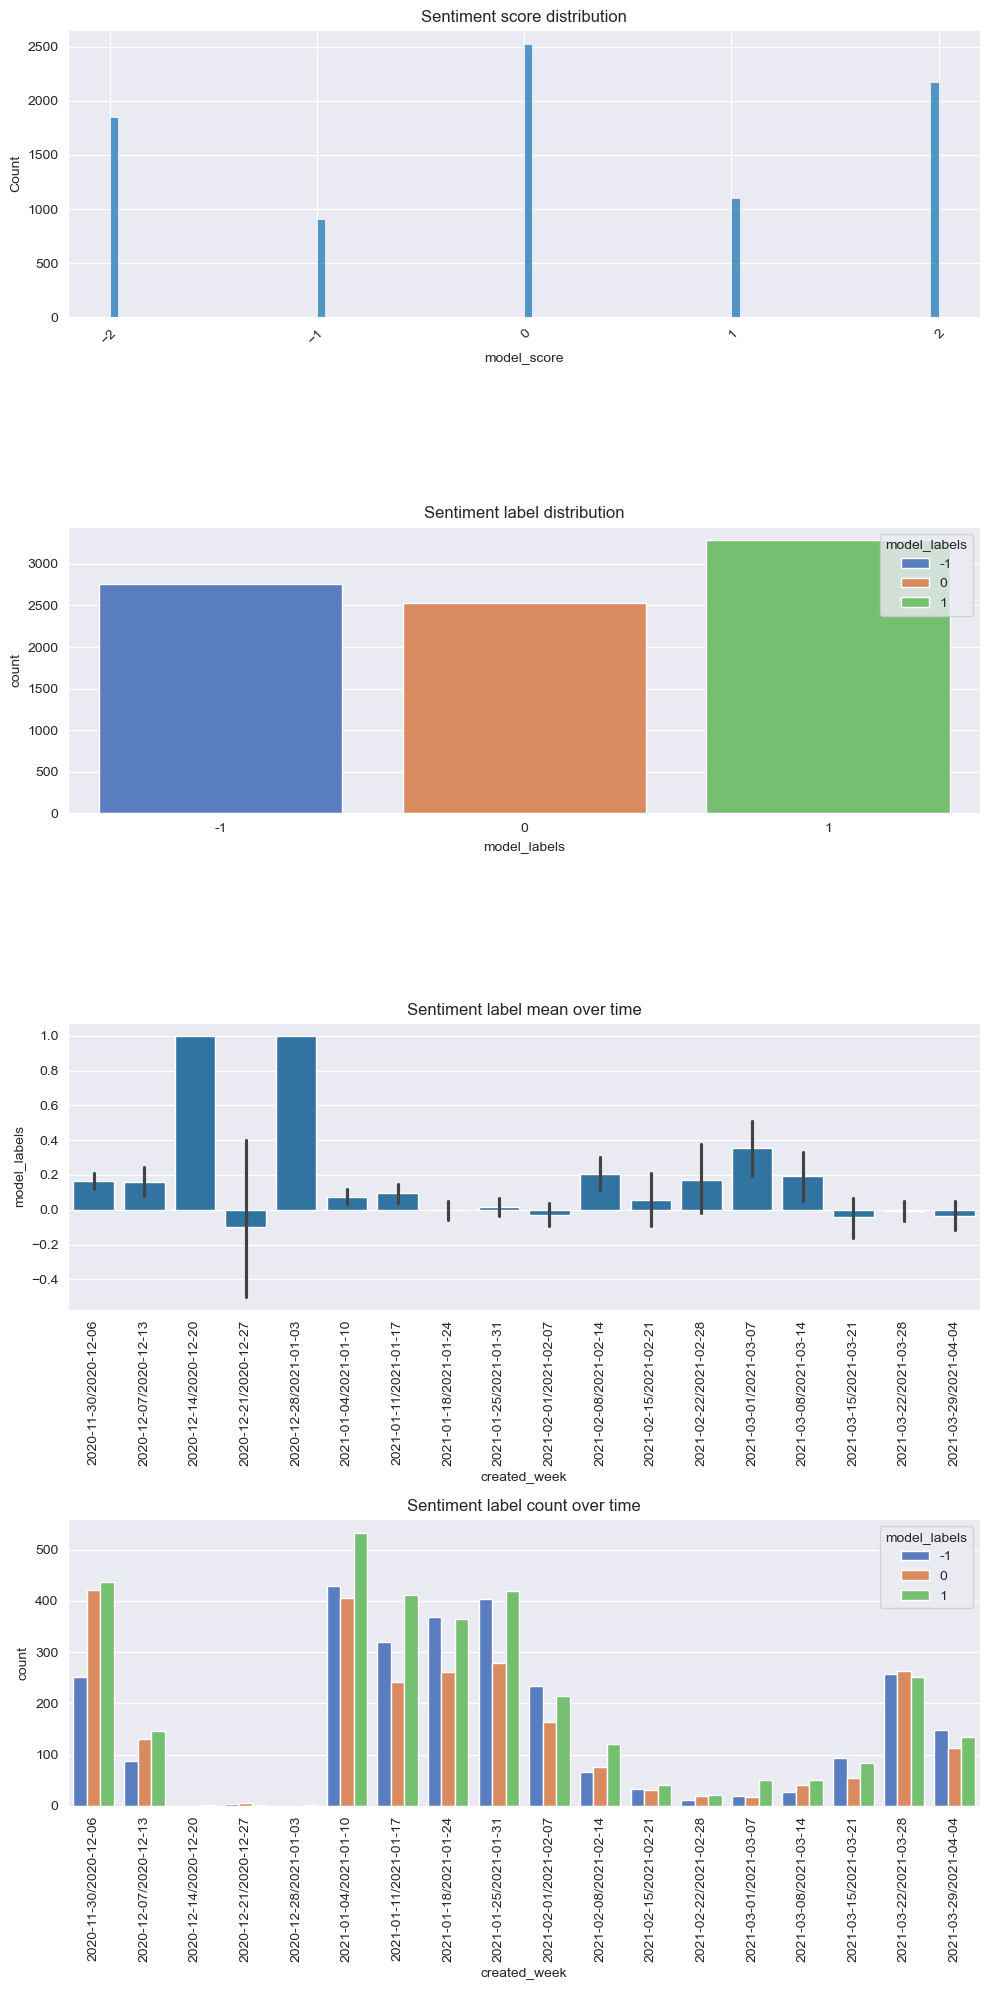

In [37]:
plot_results(df_ending_comments, score_col='model_score', 
             label_col='model_labels', time_col='created_week',
             min_time='2020-12', max_time='2021-04')

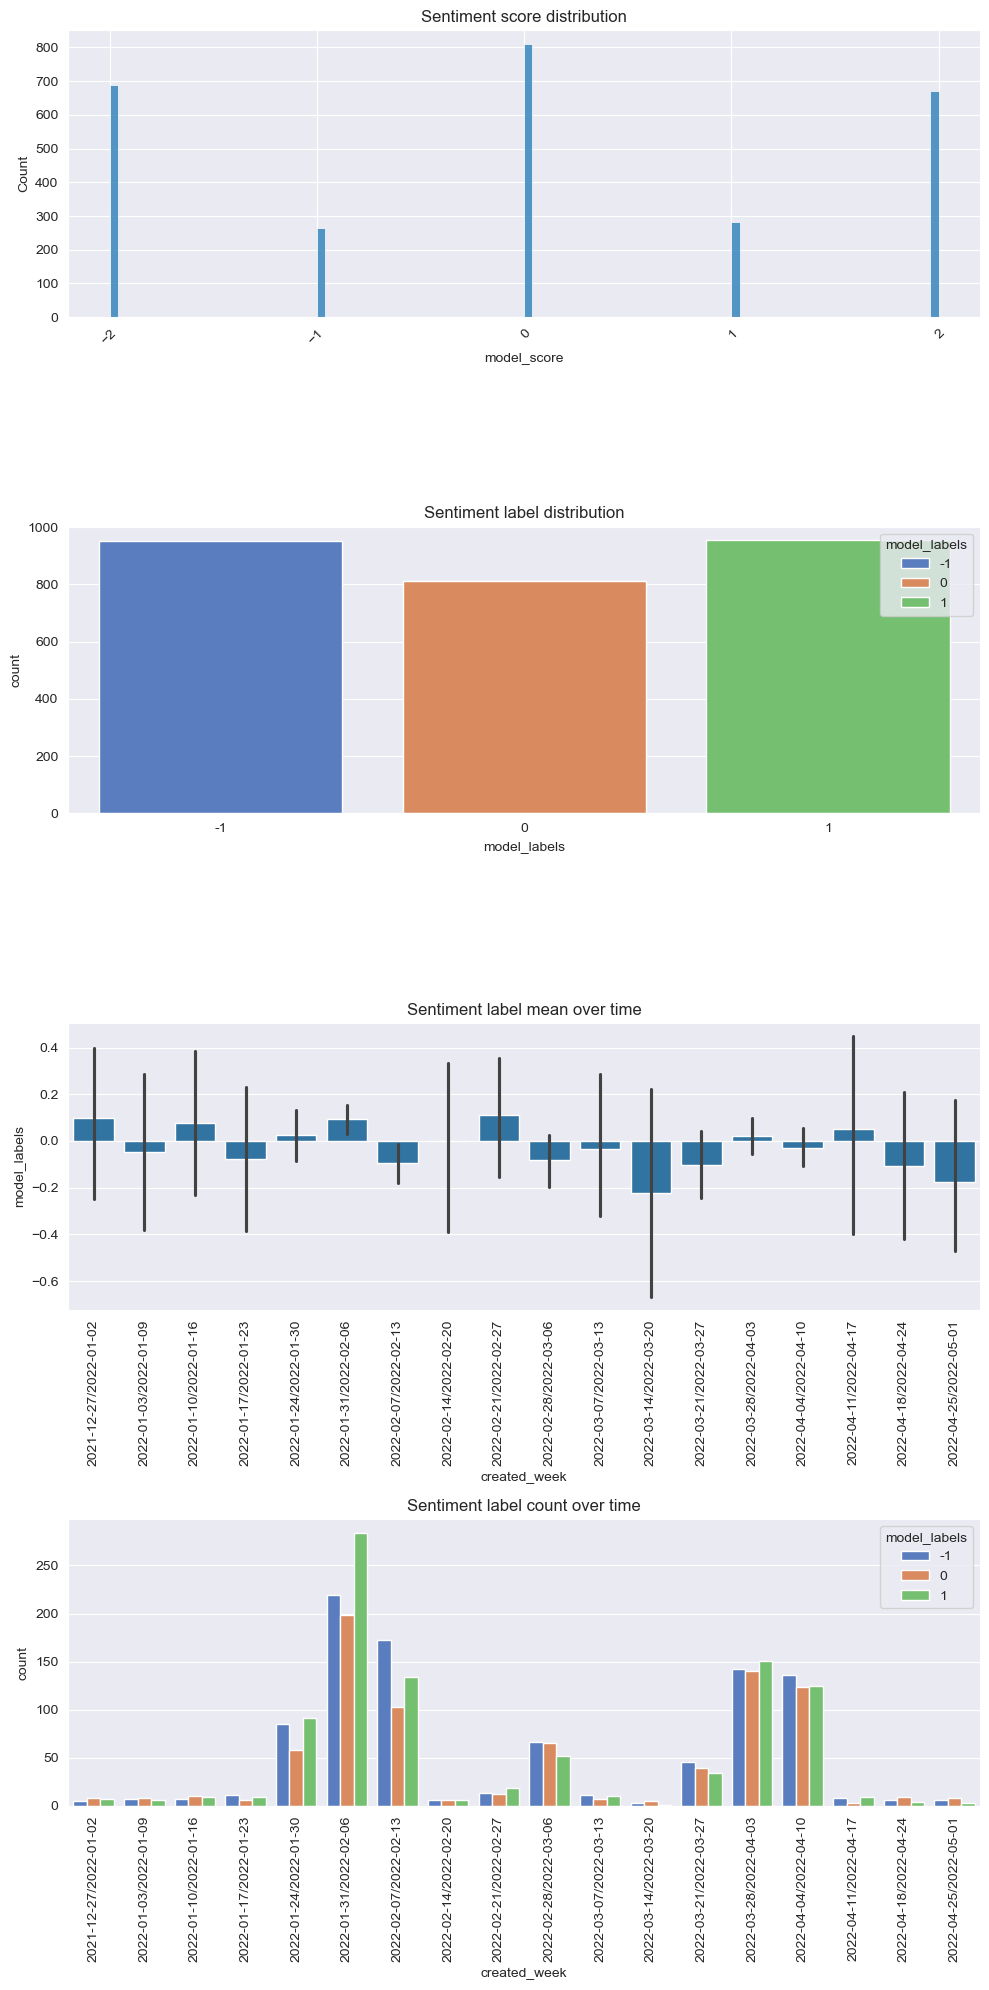

In [42]:
plot_results(df_ending_comments, score_col='model_score', 
             label_col='model_labels', time_col='created_week',
             min_time='2022-01', max_time='2022-05')

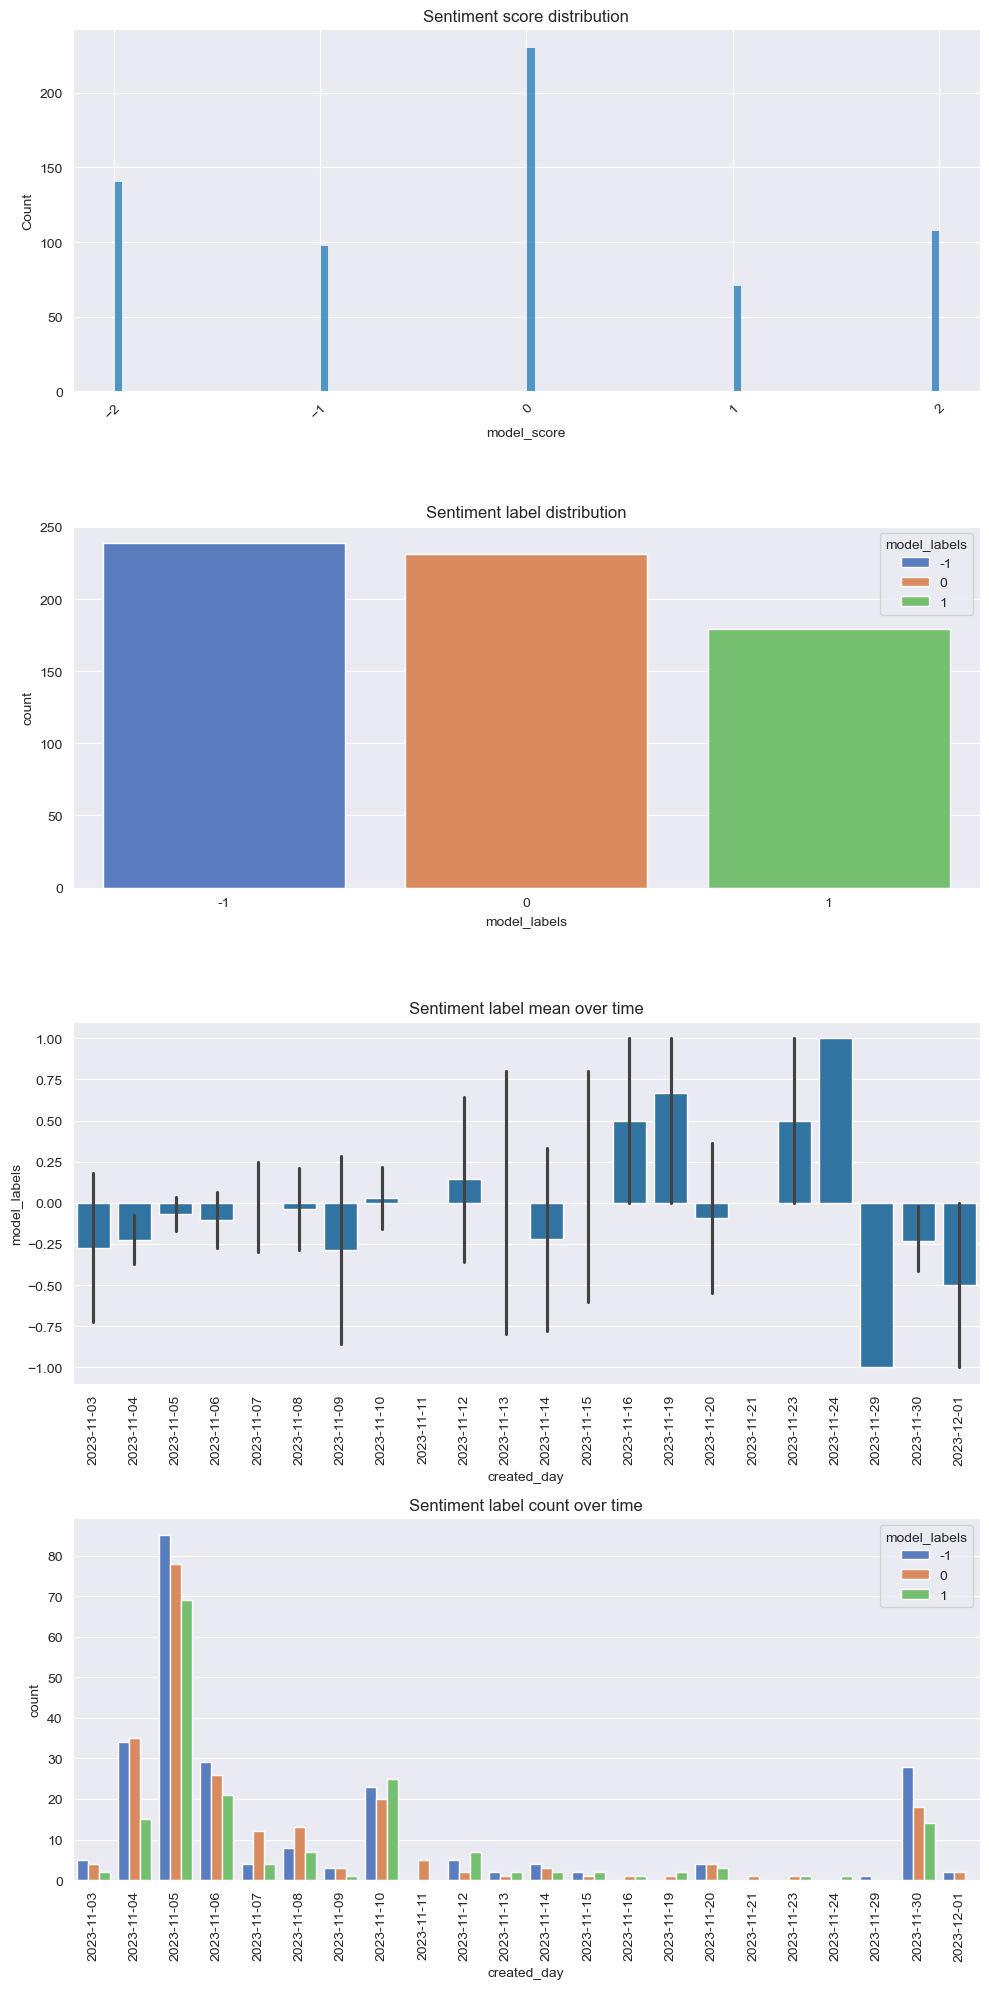

In [34]:
plot_results(df_ending_comments, score_col='model_score', 
             label_col='model_labels', time_col='created_day',
             min_time='2023-11', max_time='2023-12')

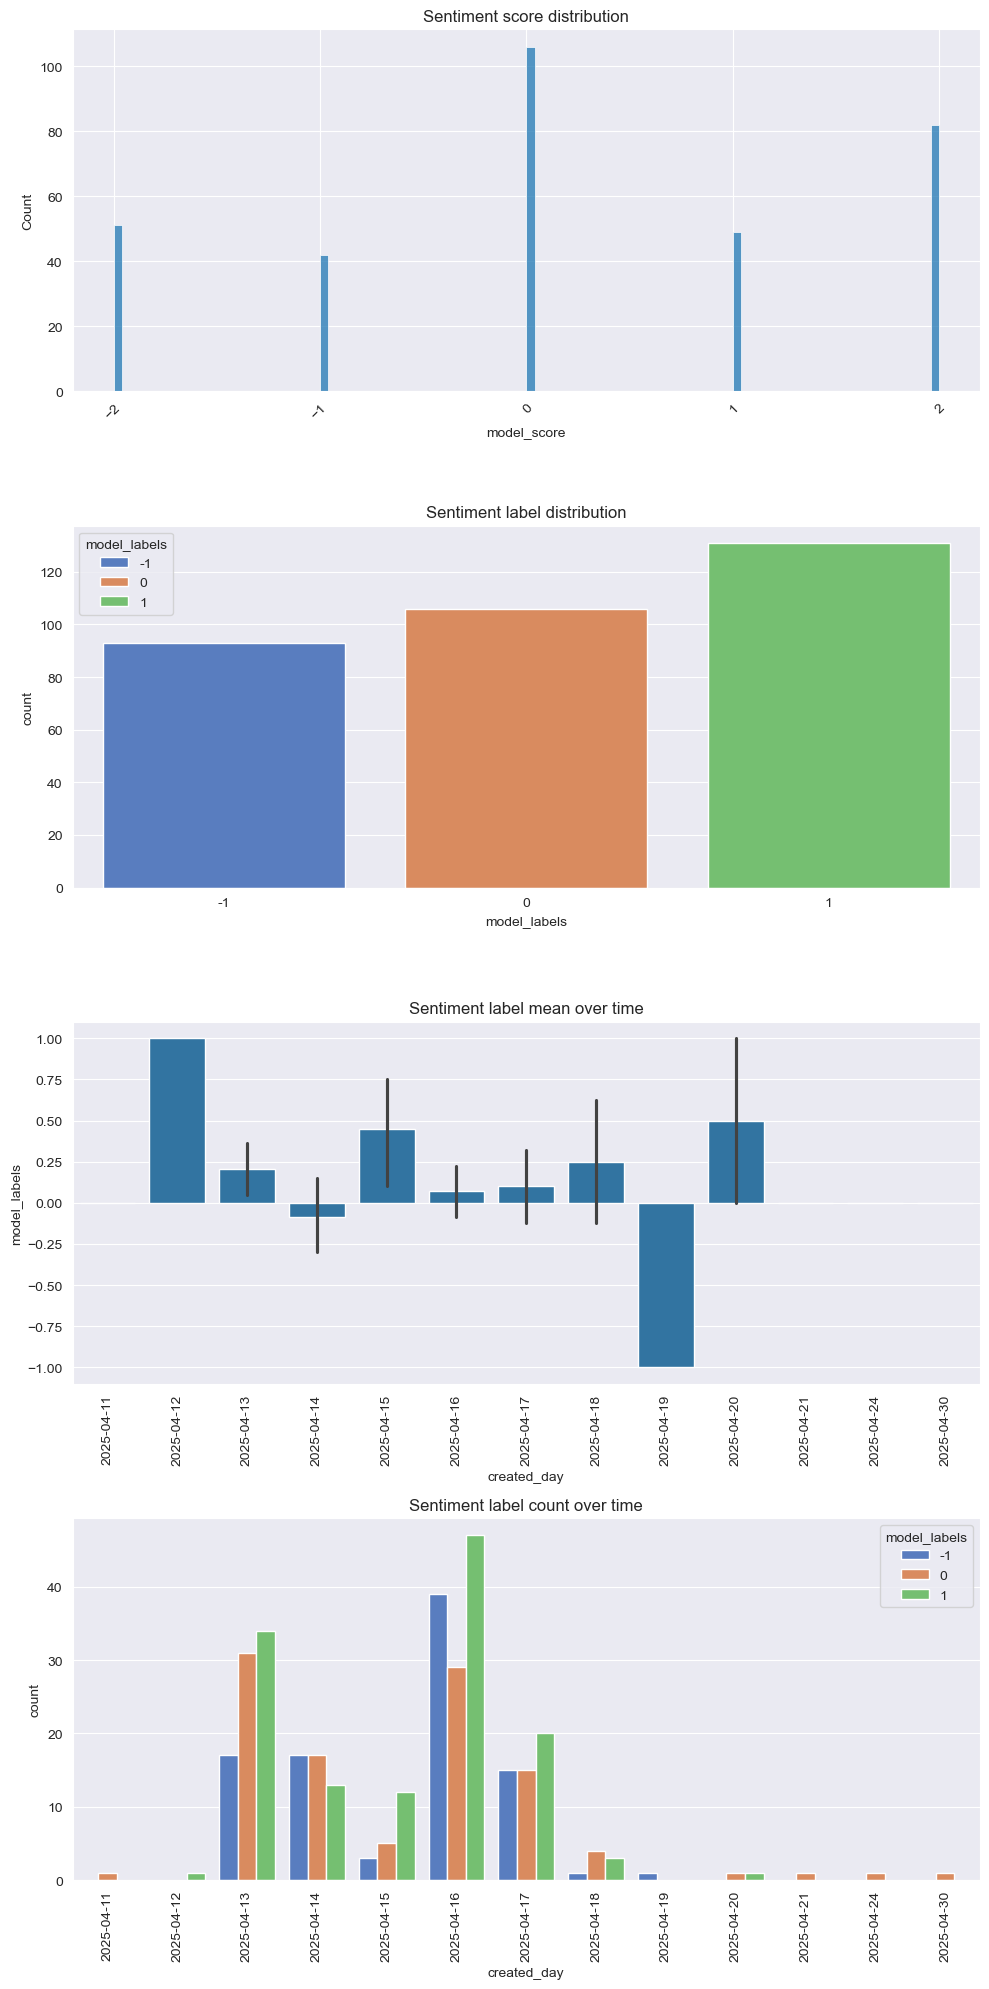

In [35]:
plot_results(df_ending_comments, score_col='model_score', 
             label_col='model_labels', time_col='created_day',
             min_time='2025-04', max_time='2025-05')

In [36]:
df_ending_comments.to_csv("../data/comments_graph_ending_final_wscores.csv")

### Observations

##### First Spike: Manga Ending

In all methods, in the first spike, the mean of labels stayed around 0, the neutral value, while the variance is quite low. This is surprising, as the number of user replies in this period makes almost more than half of the total count. Usually such high volume correlates with either strongly positive or negative swings, but here it doesn’t.

This can indicate two things:
- Each post in this period had many discussions, and both opinions are voiced in each and every one of the posts;
- Both opinions are voiced in many individual posts, not necessarily every post.
It is unlikely that echo chambers are numerous in this period, as we have a high count of both positive and negative replies, indicating polarized debates. No dominant opinion that takes over the conversation.

Overall, even if the period is mostly balanced, there's slightly more support towards positive opinions. The peak in 2021-01-10 coincides with the manga ending release date, and discussion slowly reduces over time.

##### Second Spike: Season 4, Part 2 Anime Airing

Looking at the first two graphs, the overall period is characterized by a mean neutral stance, but still, with significant polarized opinions. Positive and negative replies counts are quite balanced. In particular, instead of a big spike, we have three smaller ones:
- During 2022-01-24 to 2022-02-13, we have emotional moments between Eren and Zeke, Eren's father and Ymir's backstory, and the fall of the wall.
- During 2022-02-28 to 2022-03-06, we have the gathering of former enemies, and Connie's moral dilemma.
- During 2022-03-28 to 2022-04-10, we have insights on Eren's transformation and choices.
All of which have many points for debate. Echo chambers, again, are unlikely during this period.

##### Third Spike: Season 4, Anime Ending
This and the last spike have a smaller period range, so we will analyze days instead of weeks. Unlike the first spike, here we have a slight majority who has negative feelings, but again, the debates are still quite polarized and balanced. Multiple perspectives are present, indicating low chances of having an echo chamber. Debates are centered around:
- The battle agains Eren, now fully fused with the Founding Titan.
- Eren's freedom philosophy, contrasted with the genocide he caused.
- The Rumbling consequences, and Eren's death by Mikasa, some praising it as Poetic, others as stripping Eren agency.
- Anime ending changes from the manga.
- Lack of clear ending message.
- Tree scene: Titan might return.
All these themes caused the community to lean towards a negative sentiment, but only ever so slightly, and mostly around the release date, Nov 4 2023 (USA) and Nov 5 2023 (EU & JP).
The former (USA) has a higher negative sentiment towards the ending, as the mean is centered around small negative values, but the variance pushes it even lower. We have them a semi-polarized discussion, where positive voices exists, but are marginized. Echo chambers are possible, but given the amount of neutral voices, some are staying detached or with a neutral view.
The same applies for the latter (EU & JP), but the difference is not as big: negativity still reigns, but by a way less degree. 


# Sentiment Analysis: By Communities

We extract the main communities, and perform sentiment analysis on the subset. We want to see if certain communities have more tendencies to support or to criticize. 



In [45]:
df_communities = pd.read_csv("../data/communities.csv")
df_communities['infomap_community'].value_counts()

infomap_community
0     6357
1      843
2      726
3      377
4      260
5      218
7      191
6      175
8      146
9      145
10      85
11      79
12      75
13      28
14      14
Name: count, dtype: int64

We use infomap as community detection technique. Here, community indexes are ordered by size. We take the top 3, the largest ones, and perform sentiment analysis on them. 

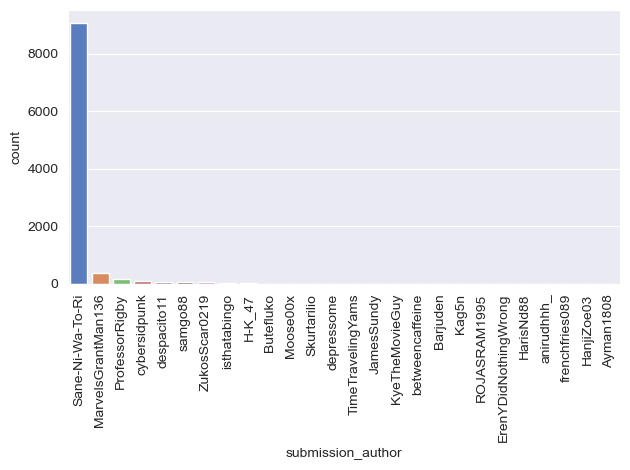

,submission_author,count
0,Sane-Ni-Wa-To-Ri,9065
1,MarvelsGrantMan136,368
2,ProfessorRigby,168
3,cybersidpunk,99
4,despacito11,75
5,samgo88,71
6,ZukosScar0219,55
7,isthatabingo,45
8,H-K_47,39
9,Butefluko,9


In [68]:
c0_users = df_communities[df_communities["infomap_community"] == 0]["node"].unique().tolist()
df_c0_comments = df_ending_comments[df_ending_comments["submission_author"].isin(c0_users)]
counts = df_c0_comments["submission_author"].value_counts().reset_index()
counts.columns = ["submission_author", 'count']
plt.xticks(rotation=90)
sns.barplot(counts, x="submission_author", y='count', hue="submission_author", palette='muted')
plt.tight_layout()
plt.show()
counts

Sane-Ni-Wa-To-Ri is the most active user in the whole subreddit. After the first analysis, we might want to focus more on them, or on the community without them. They might tip the scale of positivity/negativity/neutrality in a significant way.

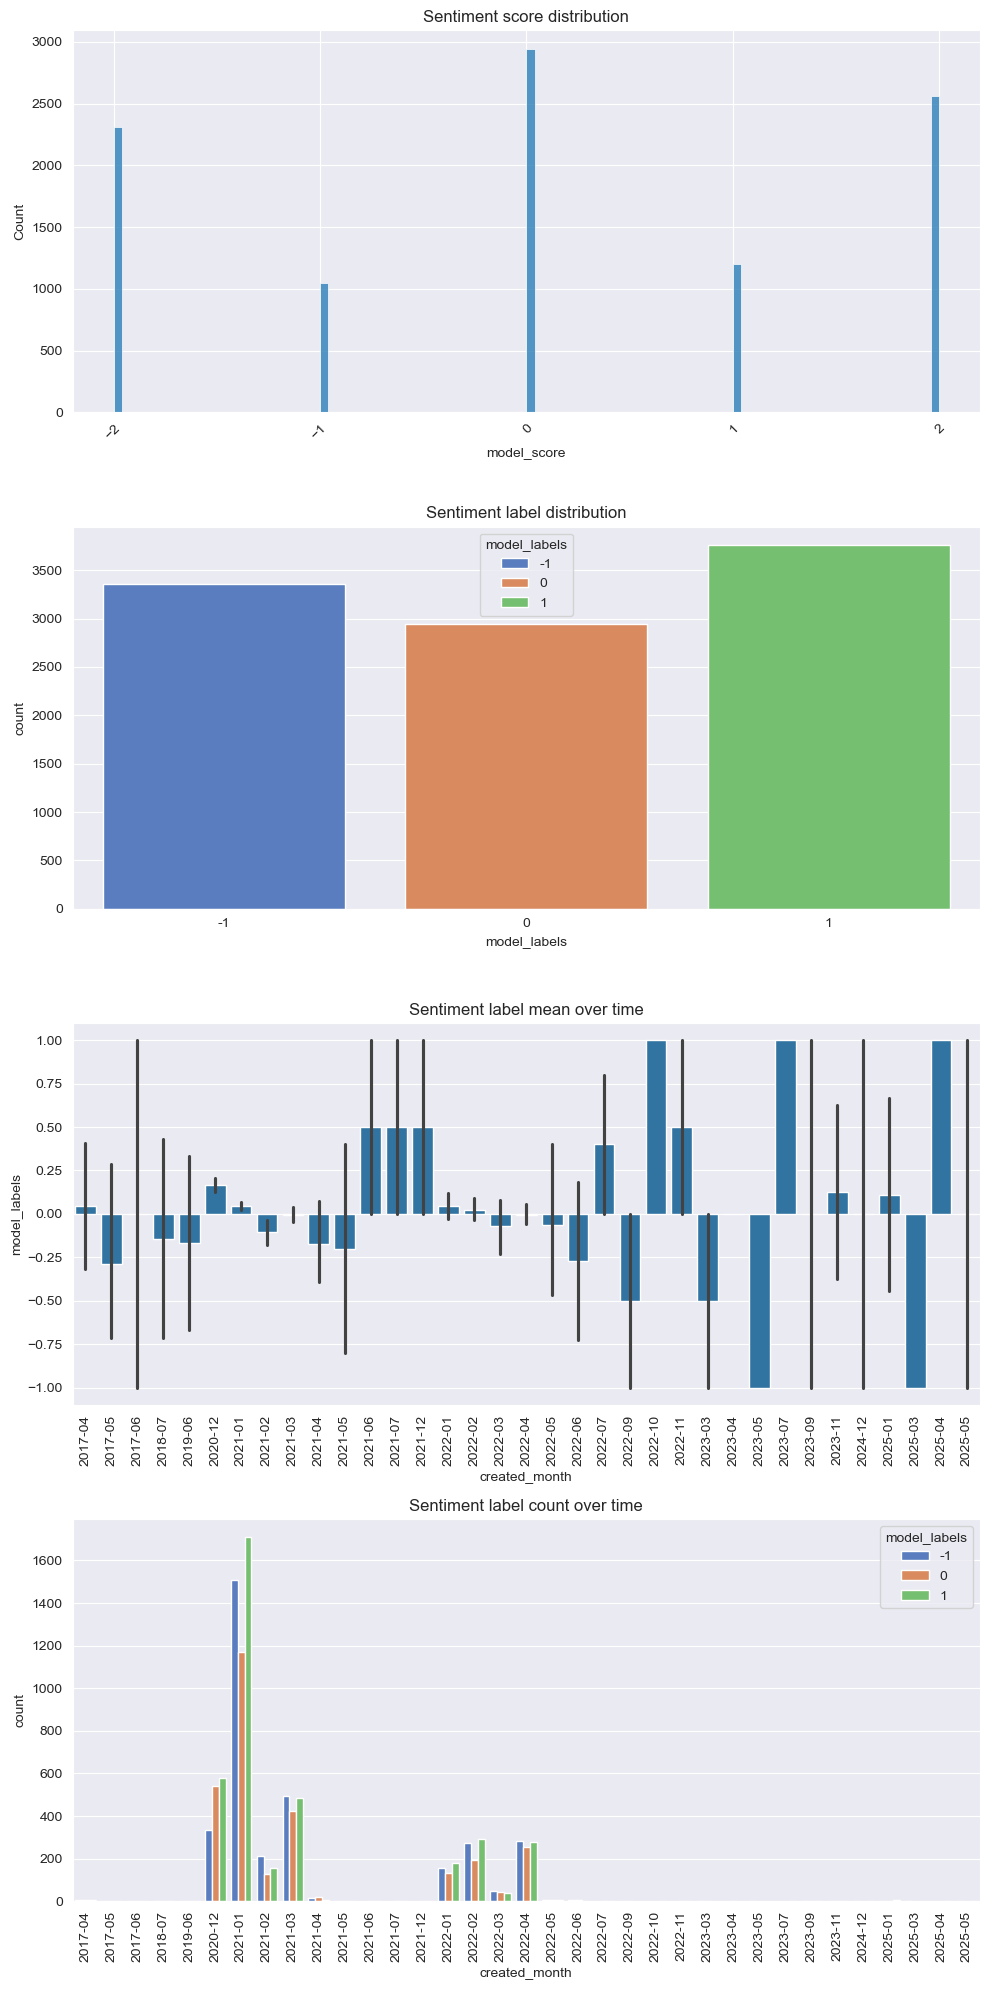

In [56]:
plot_results(df_c0_comments, score_col='model_score', label_col='model_labels', time_col='created_month')

Honestly, not big changes from what we'd usually see in the whole dataset. Maybe a slight bias towards positive voices. Let's now do the same for Sane-Ni-Wa-To-Ri only.

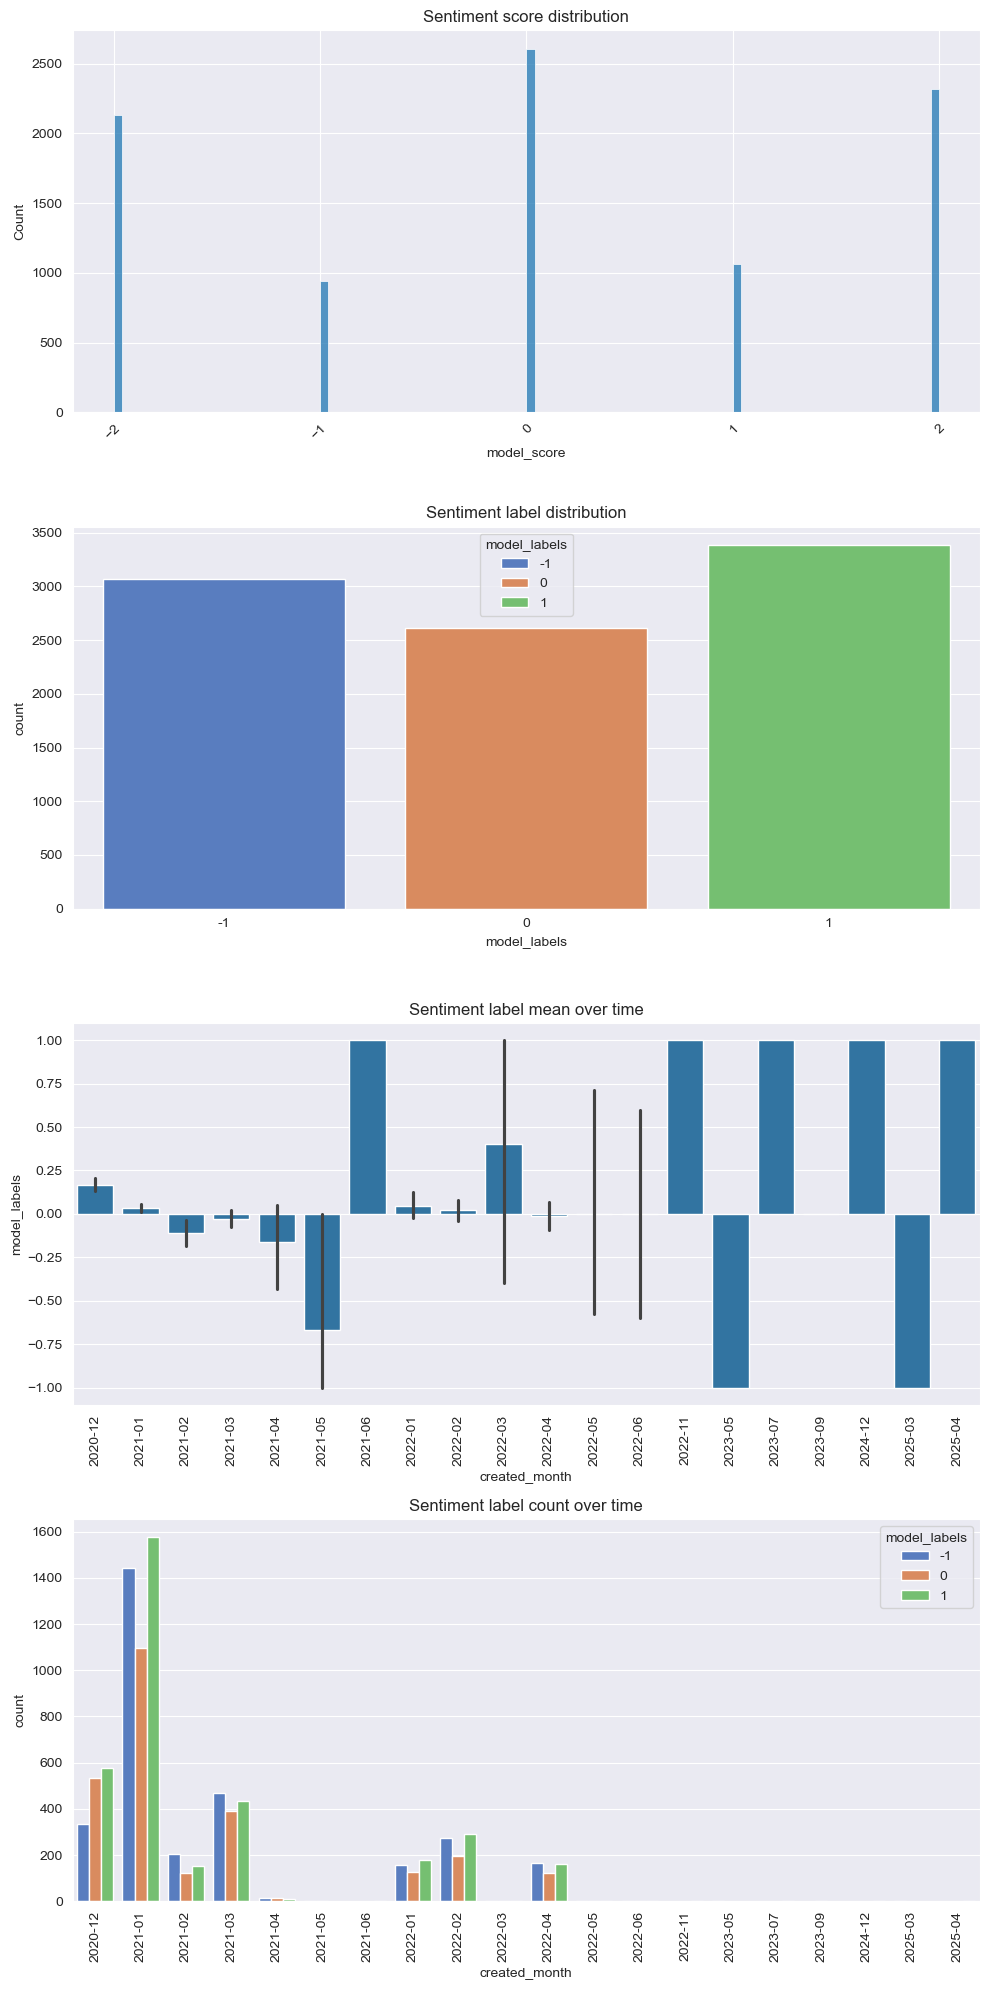

In [57]:
df_c0_sane = df_c0_comments[df_c0_comments["submission_author"] == "Sane-Ni-Wa-To-Ri"]
plot_results(df_c0_sane, score_col='model_score', label_col='model_labels', time_col='created_month')

Pretty much unchanged. What about the community without them?

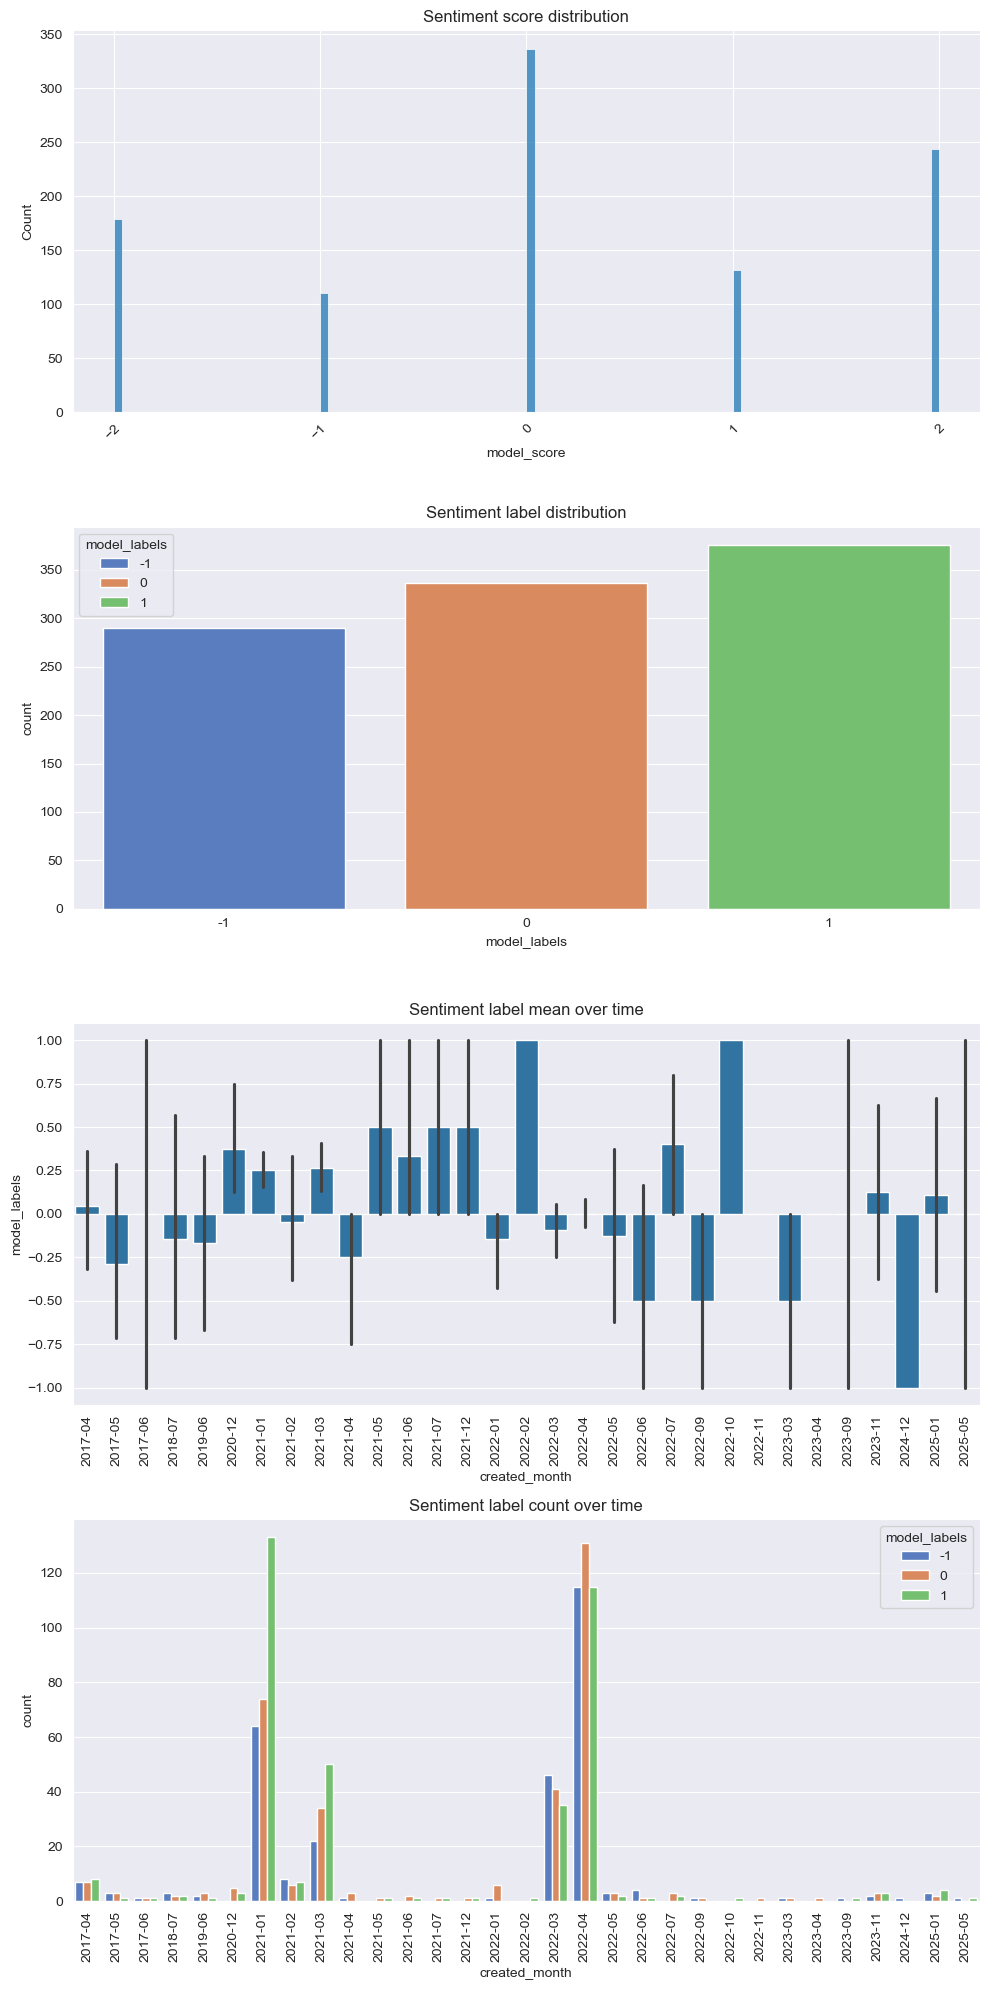

In [58]:
df_c0_no_sane = df_c0_comments[df_c0_comments["submission_author"] != "Sane-Ni-Wa-To-Ri"]
plot_results(df_c0_no_sane, score_col='model_score', label_col='model_labels', time_col='created_month')

This community overwhelmingly voiced positive opinions in the manga ending period, and balanced opinions during the anime's last season. They are equally active in both the manga ending period and the anime ending period. 

Time for the second community, index 1.

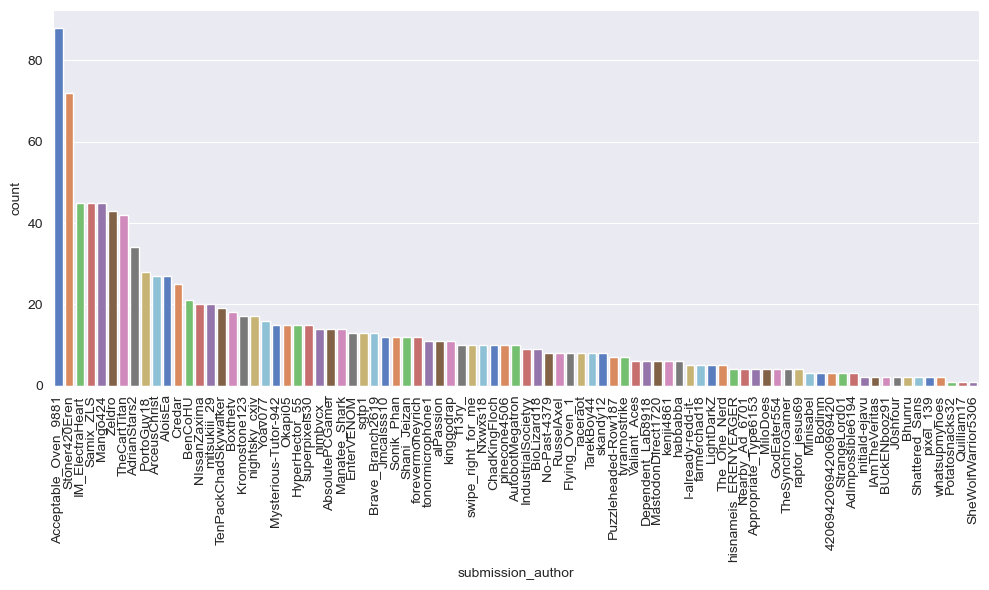

,submission_author,count
0,Acceptable_Oven_9881,88
1,Stoner420Eren,72
2,IM_ElectraHeart,45
3,Samix_ZLS,45
4,Mango424,45
...,...,...
80,pixel_139,2
81,whatsupmyhoes,2
82,Potatosnacks32,1
83,Quilliam17,1


In [71]:
c1_users = df_communities[df_communities["infomap_community"] == 1]["node"].unique().tolist()
df_c1_comments = df_ending_comments[df_ending_comments["submission_author"].isin(c1_users)]
counts = df_c1_comments["submission_author"].value_counts().reset_index()
counts.columns = ["submission_author", 'count']
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
sns.barplot(counts, x="submission_author", y='count', hue="submission_author", palette='muted')
plt.tight_layout()
plt.show()
counts

We can see how the user interaction counts are much more spread out. No Sane-Ni-Wa-To-Ri situation here.

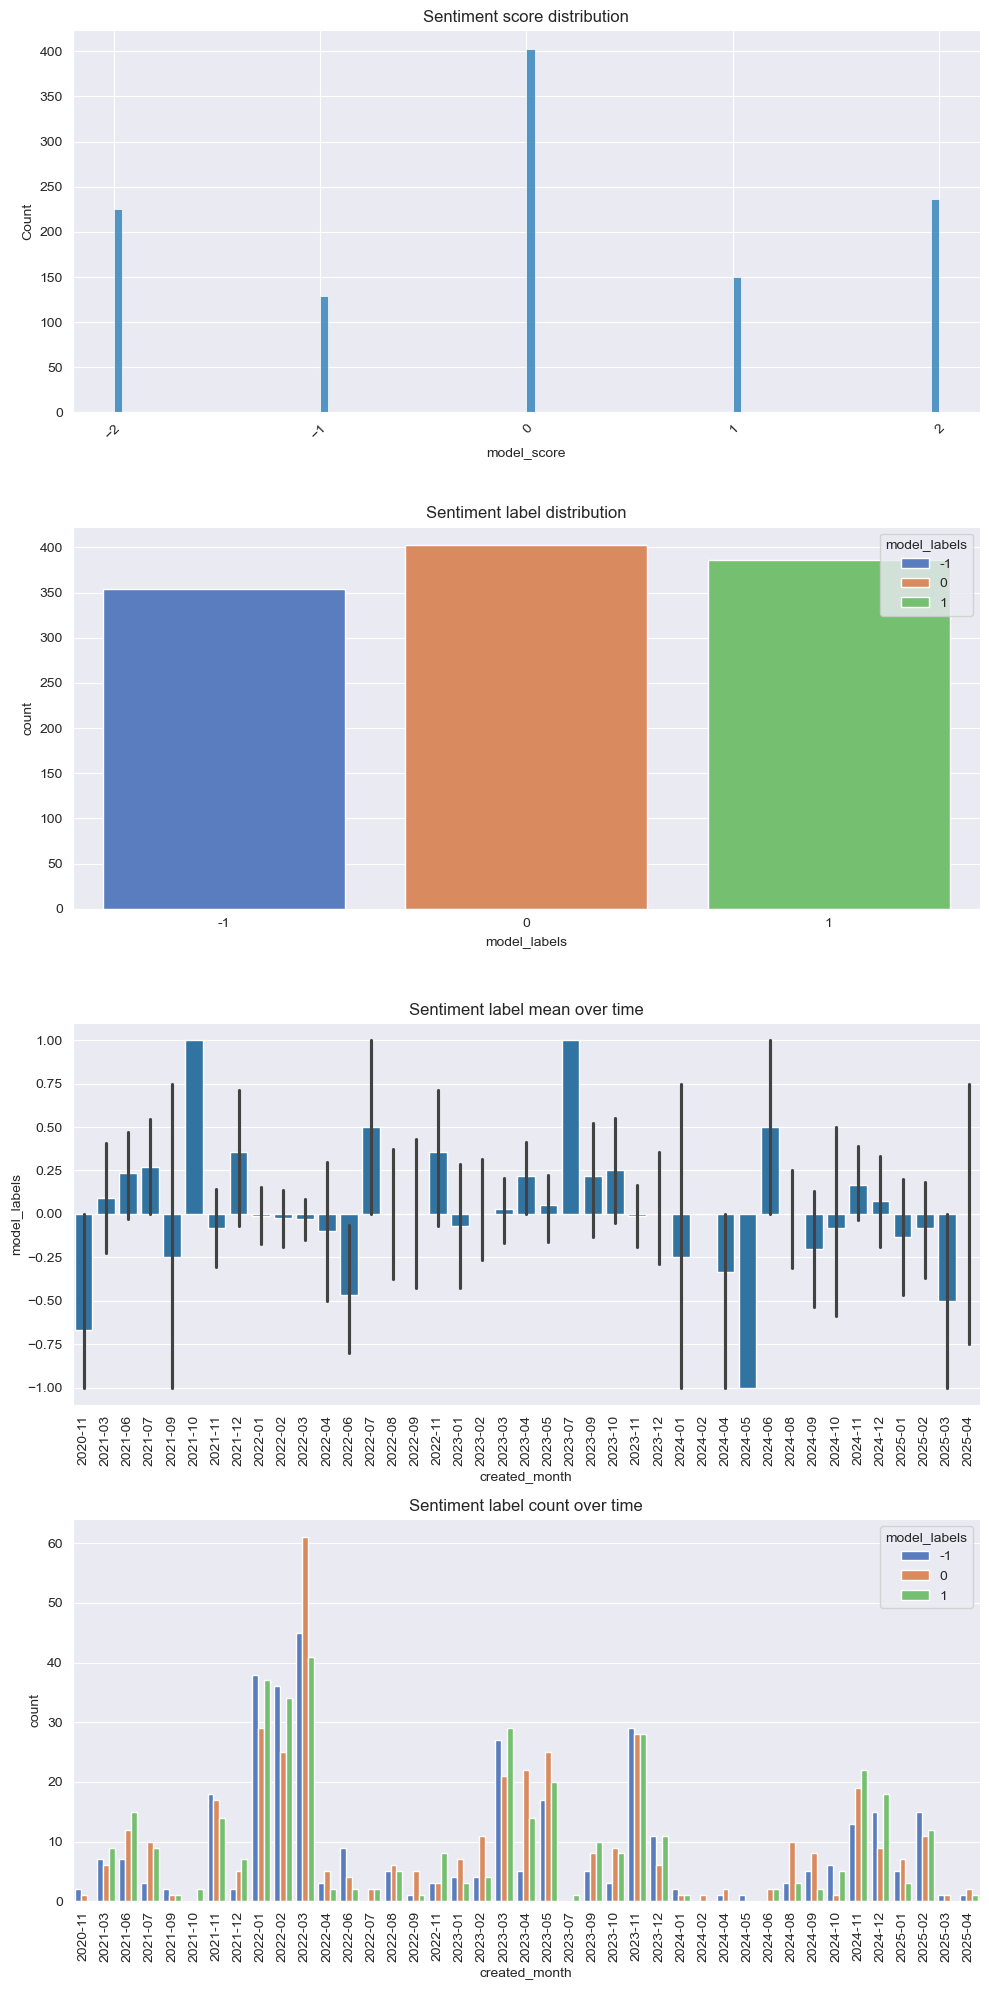

In [65]:
plot_results(df_c1_comments, score_col='model_score', label_col='model_labels', time_col='created_month')

This community instead mostly voices neutral opinions, and has balanced positive and negative voices. The presence is mainly focused on the manga ending, with interactions during the anime ending period almost halved.

Lastly, let's look into the third biggest community.

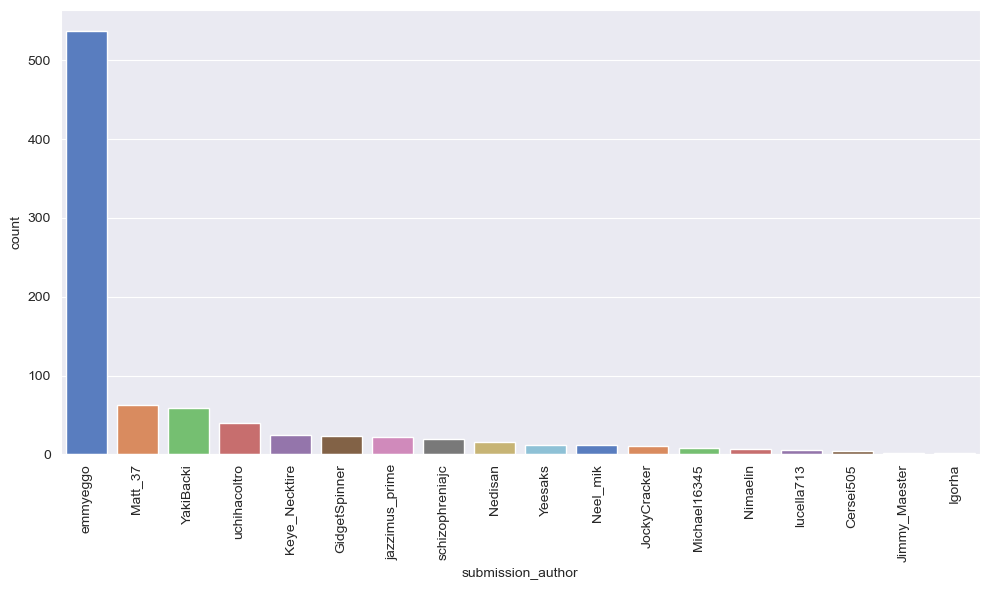

,submission_author,count
0,emmyeggo,537
1,Matt_37,62
2,YakiBacki,59
3,uchihacoltro,40
4,Keye_Necktire,24
5,GidgetSpinner,23
6,jazzimus_prime,22
7,schizophreniajc,19
8,Nedisan,16
9,Yeesaks,12


In [72]:
c2_users = df_communities[df_communities["infomap_community"] == 2]["node"].unique().tolist()
df_c2_comments = df_ending_comments[df_ending_comments["submission_author"].isin(c2_users)]
counts = df_c2_comments["submission_author"].value_counts().reset_index()
counts.columns = ["submission_author", 'count']
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
sns.barplot(counts, x="submission_author", y='count', hue="submission_author", palette='muted')
plt.tight_layout()
plt.show()
counts

We have emmyeggo who stands out much more in user interaction counts. Let's see what their sentiment distribution is like.

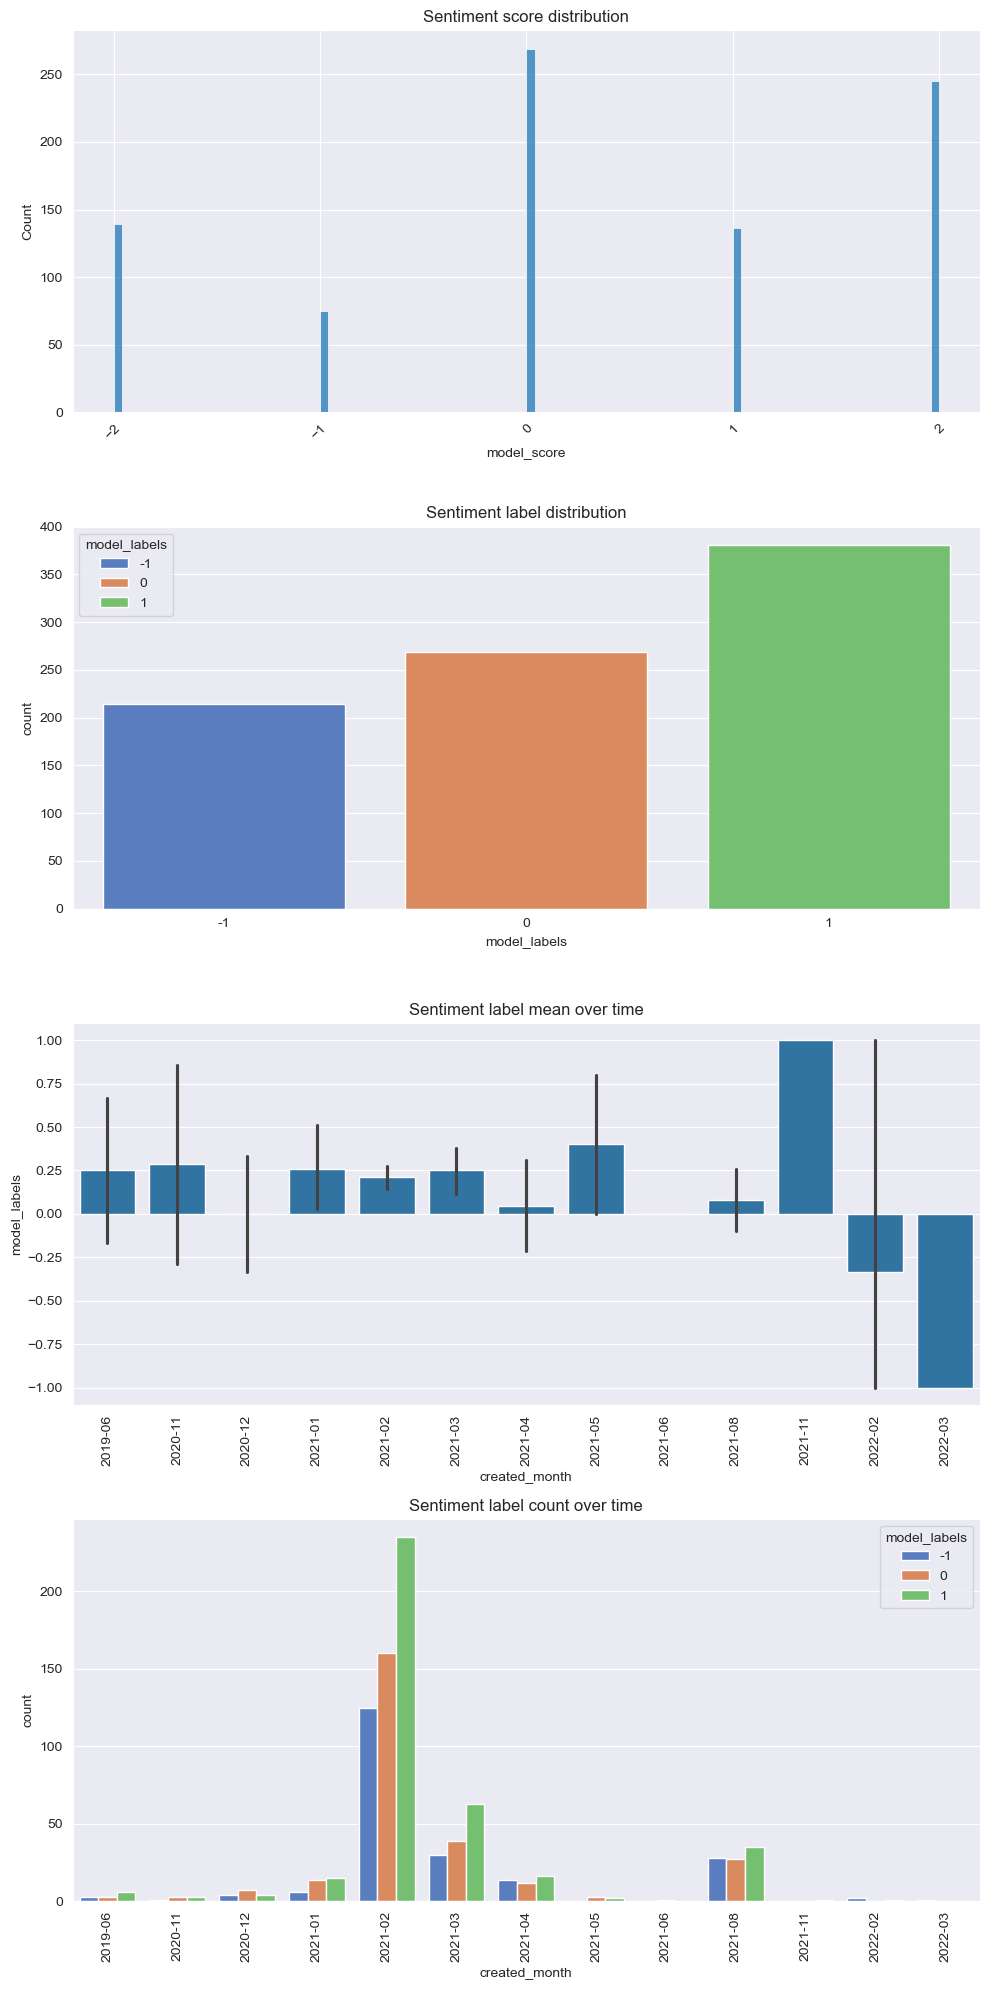

In [73]:
plot_results(df_c2_comments, score_col='model_score', label_col='model_labels', time_col='created_month')

This looks like a manga only group, since all users went silent right before the anime ending airing. This community tends to voice positive opinions, especially during the manga ending period. Positive voices almost doubles the negative ones, while still having a small group advocating towards negative replies. 